In [149]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# **1_Загрузка_данных**

In [150]:
df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
df.head(4)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.dtypes

In [158]:
import torch
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, models, datasets
import torch.nn as nn
import torch.optim as optim

import os
import time
import glob
from tqdm import tqdm
from collections import defaultdict
from IPython.display import clear_output
%matplotlib inline
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# **2_Разбивка_данных_train/val**

In [152]:
# Разбивка данных на основе индекса
from sklearn.model_selection import train_test_split
trn_ids, val_ids = train_test_split(df.index, test_size=0.3, random_state=99)
# типа разбивка df на train_df и val_df на основе разбивки train_test_split
trn_df, val_df = df[df.index.isin(trn_ids)], df[df.index.isin(val_ids)]
#print(trn_df, val_df)
len(trn_df), len(val_df)

(29400, 12600)

In [ ]:
# trn_ids, val_ids = train_test_split(trn_df.index, test_size=0.3, random_state=99)
# trn_df, val_df = df[df.index.isin(trn_ids)], df[df.index.isin(val_ids)]
# len(trn_df), len(val_df)

In [154]:
# сбрасываем индексы
trn_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [155]:
trn_df.label.value_counts()

label
1    3276
7    3129
3    2985
9    2910
4    2908
2    2898
0    2877
6    2872
8    2849
5    2696
Name: count, dtype: int64

In [156]:
val_df.label.value_counts()

label
1    1408
3    1366
2    1279
9    1278
7    1272
6    1265
0    1255
8    1214
4    1164
5    1099
Name: count, dtype: int64

**определили trn_df, val_df**

# **3_Компановка_даннх**

(28, 28, 3)


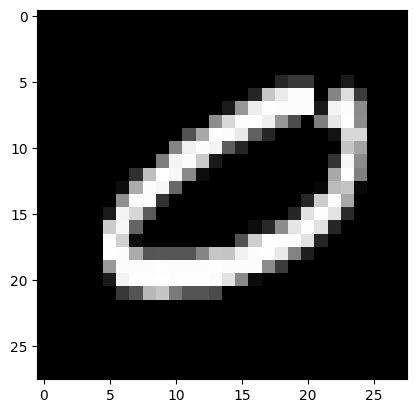

In [157]:
t = np.array(df.iloc[np.random.randint(300),1:]).reshape(28,-1)
pic=[]
for i in np.arange(3):
    pic.append(t)
arrImg = np.array(pic).transpose(1, 2, 0)
print(arrImg.shape)

# должен быть массив array, форма (28, 28, 3)
plt.imshow(arrImg)

In [ ]:
# class Asbooka(Dataset):
#     def __init__(self, df):
#         self.df = df
#         self.pics = np.array(df.iloc[:,1:])
#         self.targets = np.array(df.iloc[:,0])
#         self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
#     def __len__(self): return len(self.targets)
#     def __getitem__(self, ix):
        
#         f = self.pics[ix].reshape(28,-1)
#         pic=[]
#         for i in np.arange(3):
#             pic.append(f)
#         im = np.array(torch.tensor(pic).permute(1,2,0))
#         im = cv2.resize(im.astype('float32'), (224,224))
#         im = torch.tensor(im/255)
#         im = im.permute(2,0,1)
#         im = self.normalize(im) 
#         target = self.targets[ix]
#         return im.float(), torch.tensor(target)

In [ ]:
# def get_data():
#     train = Asbooka(trn_df)
#     trn_dl = DataLoader(train, batch_size=64, shuffle=True, drop_last = True)
#     val = Asbooka(val_df)
#     val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
#     return train, trn_dl, val_dl
# train, trn_dl, val_dl = get_data()

In [ ]:
# # train = Asbooka(val_dl)
# for i in train:
#     print(i)
#     break

# **4_Вытаскиваем_модель,_меняем_слои**

In [189]:
from torch.optim import SGD, Adam
import torch.nn as nn
def get_model():
    class neuralnet(nn.Module):
        def __init__(self):
            super().__init__()
            model = models.resnet18()
            #------------------------------
            # меняем выходной слой
            model.fc = nn.Linear(in_features=512, out_features=10)
#             model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
#             model.fc = nn.Sequential(
#               nn.Flatten(),
#               nn.Linear(512, 128), # 512 for resnet18 or 2048 for resnet 50
#               nn.ReLU(inplace=True),
#               nn.Dropout(.2),
#               nn.Linear(128, 1),
#               nn.Sigmoid()
#             )
            #------------------------------
            # замораживаем слои
            freeze_layers = [model.layer1, model.layer2, model.conv1, model.bn1]#, model.layer3]
            for layer in freeze_layers:
               for param in layer.parameters():
                 param.requires_grad = False
            #------------------------------
            self.model = model
        def forward(self, x):
            x = self.model(x)
            return x
    model = neuralnet().model

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.01)
    return model.to(device), loss_fn, optimizer
model, loss_fn, optimizer = get_model()

In [191]:
optimizer = Adam(model.parameters(), lr=0.001)

In [ ]:
# здесь разбиваются скорости корректировок для весов и смещений
# optm = torch.optim.SGD ([
#     {'params': model.weight, 'weight_decay': 0.5},
#     {'params': model.bias, 'weight_decay': 0.0}
# ],lr=1e-3)

In [ ]:
# глядим замороженные/размороженные слои
for name, param in model.named_parameters():
    print(name,param.requires_grad)

In [160]:
model.fc

Linear(in_features=512, out_features=10, bias=True)

# **Пример вставкт L1 и L2 регуляризации**

In [ ]:
#     outputs=model(inputs)
#     loss=loss_fn(outputs,labels)
    
#     #Replaces pow(2.0) with abs() for L1 regularization
     
#     l2_lambda = 0.001
#     l2_norm = sum(p.pow(2.0).sum()
#                   for p in model.parameters())
 
#     loss = loss + l2_lambda * l2_norm

In [ ]:
# Оптимизатор SGD в PyTorch уже имеет параметр weight_decay, который соответствует L2

In [ ]:
# здесь разбиваются скорости корректировок для весов и смещений
# optm = torch.optim.SGD ([
#     {'params': model.weight, 'weight_decay': 0.5},
#     {'params': model.bias, 'weight_decay': 0.0}
# ],lr=1e-3)

# **5_Аугментация**

In [161]:
IMG_SIZE = 28
# Transformations for the train
train_trans = transforms.Compose(([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
#     transforms.RandomVerticalFlip(0.4), 
#     transforms.RandomHorizontalFlip(0.4),  
#     transforms.RandomRotation(50,expand=True),
#     transforms.RandomCrop(IMG_SIZE), 
    transforms.ToTensor(), # делится на 255
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
#     transforms.Normalize((0.5,), (0.5,))
]))

# Transformations for the validation & test sets
val_trans = transforms.Compose(([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(), # divides by 255
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
   # transforms.Normalize((0.1307,), (0.3081,))
]))

In [162]:
class Asbooka(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms=transforms
        self.pics = np.array(df.iloc[:,1:])
        self.targets = np.array(df.iloc[:,0])
#         self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    def __len__(self): return len(self.df)
    def __getitem__(self, ix):
        picture = self.pics[ix]
#         pic=[]
#         for i in np.arange(3):
#           pic.append(picture)
#         print(pic)
        img = np.array(picture).astype(np.uint8)
        img = np.repeat(img.reshape(28,28,1), 3, axis=2) # делаем форму (28,28,3) из (28,28,1)
#         print(img.shape)
#         print(np.repeat(img.reshape(1,28,28), 3, axis=0).shape)
        if self.transforms:
          img=self.transforms(img).to(device)
#         print(img.shape)
        target = self.targets[ix]
        return img, torch.tensor(target).to(device)
    

In [177]:
def get_data():
    train = Asbooka(trn_df, train_trans)
    trn_dl = DataLoader(train, batch_size=254, shuffle=True, drop_last = True)
    val = Asbooka(val_df, val_trans)
    val_dl = DataLoader(val, batch_size=64, shuffle=False, drop_last = True)
    return train, trn_dl, val_dl
train, trn_dl, val_dl = get_data()

In [178]:
def show_img(img, title):
#   plt.figure(figsize=(20,20))
    npimg=img.cpu().numpy().transpose(1,2,0)
    plt.title(title)
    plt.imshow(npimg)#.transpose(1,2,0))
    plt.show()
    
kl = iter(train)

torch.Size([3, 224, 224])


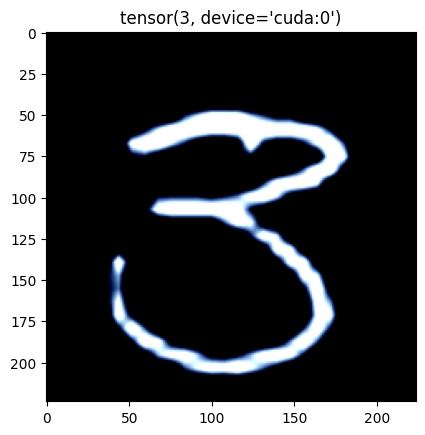

In [183]:
rr = next(kl)
print(rr[0].shape)
show_img(rr[0], rr[1])

# **5_Функции_для_train_val_вычисляющие_loss_&_accuracy**

In [184]:
def train_batch_loss_acc(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    
#     print(prediction.max(1)[1])
#     print(y)
    #-------------------------
    #loss
    loss = loss_fn(prediction, y)
#     print(loss)
#     loss = CrossEntroptLoss(prediction,y)
#     print( CrossEntroptLoss(prediction,y))
    #-------------------------
    #добавление L1-регуляризации
#     l2_lambda = 0.01
#     l2_norm = sum(p.abs().sum() for p in model.parameters())
#     batch_loss = loss + l2_lambda * l2_norm
    #-------------------------
    #добавление L2-регуляризации
    l2_lambda = 0.0001
    l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
    batch_loss = loss + l2_lambda * l2_norm
    #-------------------------
    #accuracy
    max_values, argmaxes = prediction.max(-1)
    is_correct = np.mean((argmaxes == y).double().cpu().numpy())
    #_________________________
#     print(batch_loss)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item(), is_correct

In [185]:
def val_batch_loss_acc(x, y, model, opt, loss_fn):
    model.eval()
    with torch.no_grad():
        prediction = model(x)
    #-------------------------
    #loss
    batch_loss = loss_fn(prediction, y)
#     batch_loss = CrossEntroptLoss(prediction,y)
    #-------------------------
    #accuracy
    max_values, argmaxes = prediction.max(-1)
    is_correct = np.mean((argmaxes == y).double().cpu().numpy())
    #_________________________
    return batch_loss.item(), is_correct

In [192]:
# здесь по-моему первого достаточно, добавление второго качество почти не улучшает
from torch.optim.lr_scheduler import StepLR
# scheduler_1 = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9)
scheduler_2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4], gamma=0.1)
# scheduler_3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.1, patience = 3)

# **5_Функция потерь CrossEntroptLoss**

In [ ]:
# def CrossEntroptLoss (y_pred, y_true):
#     y_pred = y_pred.max(1)[1]
#     out = (y_pred == y_true).double().numpy()
#     return 1 - np.mean(out)

# **6_Процесс_обучения**

In [ ]:
# scheduler_2.get_last_lr()[0]

In [193]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(12):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(tqdm(trn_dl)):
        x, y = batch
        batch_loss_tr, batch_accuracy_tr = train_batch_loss_acc(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss_tr)
        train_epoch_accuracies.append(batch_accuracy_tr)
        if ix%10 == 0:
            print(f'{ix} batch_train_loss: {np.array(batch_loss_tr)}')
            print(f'{ix} sum_train_loss: {np.array(train_epoch_losses).mean()}')
            print(f'{ix} batch_train_acc: {np.array(batch_accuracy_tr)}')
            print(f'{ix} sum_train_acc: {np.array(train_epoch_accuracies).mean()}', end='\r')
    train_losses.append(np.array(train_epoch_losses).mean())
    train_accuracies.append(np.array(train_epoch_accuracies).mean())
    
    val_epoch_losses, val_epoch_accuracies = [], []
    for ix, batch in enumerate(tqdm(val_dl)):
        x, y = batch
        batch_loss_val, batch_accuracy_val = val_batch_loss_acc(x, y, model, optimizer, loss_fn)
        val_epoch_losses.append(batch_loss_val)
        val_epoch_accuracies.append(batch_accuracy_val)
        if ix%10 == 0:
            print(f'{ix} batch_val_loss: {np.array(batch_loss_val)}')
            print(f'{ix} sum_val_loss: {np.array(val_epoch_losses).mean()}')
            print(f'{ix} batch_val_acc: {np.array(batch_accuracy_val)}')
            print(f'{ix} sum_val_acc: {np.array(val_epoch_accuracies).mean()}', end='\r')
    #---------------------------------
    # изменение шага
    scheduler_2.step() # меняем_шаг
    print(scheduler_2.get_last_lr()[0]) # выводим_значение_шага
    #---------------------------------    
    val_losses.append(np.array(val_epoch_losses).mean())
    val_accuracies.append(np.array(val_epoch_accuracies).mean())

    
    print(f'train_losses: {train_losses}, train_accuracies: {train_accuracies}')
    print(f'val_losses: {val_losses}, val_accuracies: {val_accuracies}')

0


  1%|          | 1/115 [00:00<01:01,  1.85it/s]

0 batch_train_loss: 0.34885862469673157
0 sum_train_loss: 0.34885862469673157
0 batch_train_acc: 0.9960629921259843


 10%|▉         | 11/115 [00:05<00:55,  1.88it/s]

10 batch_train_loss: 0.3414187431335449
10 sum_train_loss: 0.352555898102847
10 batch_train_acc: 0.9921259842519685


 18%|█▊        | 21/115 [00:11<00:49,  1.91it/s]

20 batch_train_loss: 0.34829699993133545
20 sum_train_loss: 0.34801551699638367
20 batch_train_acc: 0.9921259842519685


 27%|██▋       | 31/115 [00:16<00:43,  1.92it/s]

30 batch_train_loss: 0.3370968997478485
30 sum_train_loss: 0.3457300768744561
30 batch_train_acc: 0.9960629921259843


 36%|███▌      | 41/115 [00:21<00:38,  1.92it/s]

40 batch_train_loss: 0.3338221609592438
40 sum_train_loss: 0.34427374674052724
40 batch_train_acc: 1.0


 44%|████▍     | 51/115 [00:26<00:35,  1.79it/s]

50 batch_train_loss: 0.3326954245567322
50 sum_train_loss: 0.34204432076098873
50 batch_train_acc: 1.0


 53%|█████▎    | 61/115 [00:32<00:28,  1.91it/s]

60 batch_train_loss: 0.35174113512039185
60 sum_train_loss: 0.34153452711027177
60 batch_train_acc: 0.9960629921259843


 62%|██████▏   | 71/115 [00:37<00:22,  1.92it/s]

70 batch_train_loss: 0.33083367347717285
70 sum_train_loss: 0.3402265969296576
70 batch_train_acc: 0.9960629921259843


 70%|███████   | 81/115 [00:42<00:17,  1.89it/s]

80 batch_train_loss: 0.3339747190475464
80 sum_train_loss: 0.3393422265847524
80 batch_train_acc: 0.9960629921259843


 79%|███████▉  | 91/115 [00:47<00:12,  1.93it/s]

90 batch_train_loss: 0.32544106245040894
90 sum_train_loss: 0.33808850587069333
90 batch_train_acc: 1.0


 88%|████████▊ | 101/115 [00:53<00:07,  1.91it/s]

100 batch_train_loss: 0.3365679979324341
100 sum_train_loss: 0.3376868747838653
100 batch_train_acc: 0.9921259842519685


 97%|█████████▋| 111/115 [00:58<00:02,  1.85it/s]

110 batch_train_loss: 0.33411717414855957
110 sum_train_loss: 0.3372218896139849
110 batch_train_acc: 0.9921259842519685


  1%|          | 2/196 [00:00<00:22,  8.66it/s]

0 batch_val_loss: 0.04291979968547821
0 sum_val_loss: 0.04291979968547821
0 batch_val_acc: 0.984375


  6%|▌         | 12/196 [00:01<00:21,  8.67it/s]

10 batch_val_loss: 0.10915610939264297
10 sum_val_loss: 0.027909913121468642
10 batch_val_acc: 0.96875


 11%|█         | 22/196 [00:02<00:20,  8.58it/s]

20 batch_val_loss: 0.03546811640262604
20 sum_val_loss: 0.027372471772001257
20 batch_val_acc: 0.984375


 16%|█▋        | 32/196 [00:03<00:19,  8.61it/s]

30 batch_val_loss: 0.026780355721712112
30 sum_val_loss: 0.03172989186996053
30 batch_val_acc: 0.984375


 21%|██▏       | 42/196 [00:04<00:17,  8.75it/s]

40 batch_val_loss: 0.003877553390339017
40 sum_val_loss: 0.031370676907699374
40 batch_val_acc: 1.0


 27%|██▋       | 52/196 [00:06<00:16,  8.71it/s]

50 batch_val_loss: 0.031445279717445374
50 sum_val_loss: 0.03160992284949102
50 batch_val_acc: 1.0


 32%|███▏      | 62/196 [00:07<00:15,  8.64it/s]

60 batch_val_loss: 0.005403035786002874
60 sum_val_loss: 0.028744039993130098
60 batch_val_acc: 1.0


 37%|███▋      | 72/196 [00:08<00:14,  8.57it/s]

70 batch_val_loss: 0.05761409550905228
70 sum_val_loss: 0.028615886329929015
70 batch_val_acc: 0.96875


 42%|████▏     | 82/196 [00:09<00:13,  8.41it/s]

80 batch_val_loss: 0.030220650136470795
80 sum_val_loss: 0.030966162489709893
80 batch_val_acc: 0.984375


 47%|████▋     | 92/196 [00:10<00:12,  8.63it/s]

90 batch_val_loss: 0.04590988904237747
90 sum_val_loss: 0.029707075838014935
90 batch_val_acc: 0.984375


 52%|█████▏    | 102/196 [00:11<00:10,  8.63it/s]

100 batch_val_loss: 0.019086157903075218
100 sum_val_loss: 0.02902698291391872
100 batch_val_acc: 0.984375


 57%|█████▋    | 112/196 [00:12<00:09,  8.50it/s]

110 batch_val_loss: 0.02320806123316288
110 sum_val_loss: 0.030034903430606465
110 batch_val_acc: 0.984375


 62%|██████▏   | 122/196 [00:14<00:08,  8.46it/s]

120 batch_val_loss: 0.14398105442523956
120 sum_val_loss: 0.033051301956115185
120 batch_val_acc: 0.96875


 67%|██████▋   | 132/196 [00:15<00:07,  8.67it/s]

130 batch_val_loss: 0.03288118168711662
130 sum_val_loss: 0.0325969826502953
130 batch_val_acc: 0.984375


 72%|███████▏  | 142/196 [00:16<00:06,  8.69it/s]

140 batch_val_loss: 0.006353289820253849
140 sum_val_loss: 0.03233712671179298
140 batch_val_acc: 1.0


 78%|███████▊  | 152/196 [00:17<00:05,  8.66it/s]

150 batch_val_loss: 0.004109073895961046
150 sum_val_loss: 0.03105811538777641
150 batch_val_acc: 1.0


 83%|████████▎ | 162/196 [00:18<00:03,  8.71it/s]

160 batch_val_loss: 0.07581152021884918
160 sum_val_loss: 0.03057567245487459
160 batch_val_acc: 0.96875


 88%|████████▊ | 172/196 [00:19<00:02,  8.65it/s]

170 batch_val_loss: 0.02820536494255066
170 sum_val_loss: 0.029631867749161735
170 batch_val_acc: 0.984375


 93%|█████████▎| 182/196 [00:21<00:01,  8.79it/s]

180 batch_val_loss: 0.0017871435265988111
180 sum_val_loss: 0.02967937411232311
180 batch_val_acc: 1.0


 98%|█████████▊| 192/196 [00:22<00:00,  8.75it/s]

190 batch_val_loss: 0.02412095107138157
190 sum_val_loss: 0.0294631846100994
190 batch_val_acc: 0.984375


100%|██████████| 196/196 [00:22<00:00,  8.61it/s]


0.001
train_losses: [0.3370799106100331], train_accuracies: [0.9959260527216707]
val_losses: [0.029134083881069032], val_accuracies: [0.9920280612244898]
1


  1%|          | 1/115 [00:00<01:00,  1.89it/s]

0 batch_train_loss: 0.3200933039188385
0 sum_train_loss: 0.3200933039188385
0 batch_train_acc: 1.0


 10%|▉         | 11/115 [00:05<00:58,  1.78it/s]

10 batch_train_loss: 0.3305808901786804
10 sum_train_loss: 0.3296811851588162
10 batch_train_acc: 0.9960629921259843


 18%|█▊        | 21/115 [00:11<00:50,  1.87it/s]

20 batch_train_loss: 0.32013532519340515
20 sum_train_loss: 0.3268205253850846
20 batch_train_acc: 1.0


 27%|██▋       | 31/115 [00:16<00:44,  1.89it/s]

30 batch_train_loss: 0.3215253949165344
30 sum_train_loss: 0.32590542301054926
30 batch_train_acc: 1.0


 36%|███▌      | 41/115 [00:21<00:38,  1.92it/s]

40 batch_train_loss: 0.32329651713371277
40 sum_train_loss: 0.3251638492433036
40 batch_train_acc: 0.9960629921259843


 44%|████▍     | 51/115 [00:26<00:33,  1.91it/s]

50 batch_train_loss: 0.32228729128837585
50 sum_train_loss: 0.32439373871859384
50 batch_train_acc: 0.9960629921259843


 53%|█████▎    | 61/115 [00:32<00:28,  1.89it/s]

60 batch_train_loss: 0.3237297534942627
60 sum_train_loss: 0.32426103949546814
60 batch_train_acc: 0.9960629921259843


 62%|██████▏   | 71/115 [00:37<00:24,  1.80it/s]

70 batch_train_loss: 0.31576624512672424
70 sum_train_loss: 0.3241899319937531
70 batch_train_acc: 1.0


 70%|███████   | 81/115 [00:42<00:17,  1.90it/s]

80 batch_train_loss: 0.3236585855484009
80 sum_train_loss: 0.3237661553753747
80 batch_train_acc: 0.9960629921259843


 79%|███████▉  | 91/115 [00:48<00:12,  1.91it/s]

90 batch_train_loss: 0.3159905672073364
90 sum_train_loss: 0.32339501773918067
90 batch_train_acc: 1.0


 88%|████████▊ | 101/115 [00:53<00:07,  1.91it/s]

100 batch_train_loss: 0.32931968569755554
100 sum_train_loss: 0.3230367606819266
100 batch_train_acc: 0.9960629921259843


 97%|█████████▋| 111/115 [00:58<00:02,  1.92it/s]

110 batch_train_loss: 0.31341415643692017
110 sum_train_loss: 0.32295212095922177
110 batch_train_acc: 1.0


  1%|          | 2/196 [00:00<00:22,  8.69it/s]

0 batch_val_loss: 0.028053710237145424
0 sum_val_loss: 0.028053710237145424
0 batch_val_acc: 1.0


  6%|▌         | 12/196 [00:01<00:21,  8.66it/s]

10 batch_val_loss: 0.10971669107675552
10 sum_val_loss: 0.029817784099246968
10 batch_val_acc: 0.96875


 11%|█         | 22/196 [00:02<00:20,  8.54it/s]

20 batch_val_loss: 0.03858591988682747
20 sum_val_loss: 0.02855772577736172
20 batch_val_acc: 0.984375


 16%|█▋        | 32/196 [00:03<00:19,  8.60it/s]

30 batch_val_loss: 0.020169569179415703
30 sum_val_loss: 0.03096863176418288
30 batch_val_acc: 0.984375


 21%|██▏       | 42/196 [00:04<00:18,  8.55it/s]

40 batch_val_loss: 0.004769874736666679
40 sum_val_loss: 0.031522006245057396
40 batch_val_acc: 1.0


 27%|██▋       | 52/196 [00:06<00:16,  8.69it/s]

50 batch_val_loss: 0.0335954874753952
50 sum_val_loss: 0.03101698303248222
50 batch_val_acc: 0.984375


 32%|███▏      | 62/196 [00:07<00:17,  7.47it/s]

60 batch_val_loss: 0.005599256604909897
60 sum_val_loss: 0.028044059941331384
60 batch_val_acc: 1.0


 37%|███▋      | 72/196 [00:08<00:14,  8.33it/s]

70 batch_val_loss: 0.08278843760490417
70 sum_val_loss: 0.028506680836074685
70 batch_val_acc: 0.96875


 42%|████▏     | 82/196 [00:09<00:13,  8.51it/s]

80 batch_val_loss: 0.016137059777975082
80 sum_val_loss: 0.03139716149796444
80 batch_val_acc: 1.0


 47%|████▋     | 92/196 [00:10<00:12,  8.56it/s]

90 batch_val_loss: 0.014728059060871601
90 sum_val_loss: 0.030093712320264716
90 batch_val_acc: 1.0


 52%|█████▏    | 102/196 [00:12<00:11,  8.49it/s]

100 batch_val_loss: 0.03490884229540825
100 sum_val_loss: 0.029558149496344666
100 batch_val_acc: 0.984375


 57%|█████▋    | 112/196 [00:13<00:09,  8.63it/s]

110 batch_val_loss: 0.012679694220423698
110 sum_val_loss: 0.02994282513270616
110 batch_val_acc: 1.0


 62%|██████▏   | 122/196 [00:14<00:08,  8.28it/s]

120 batch_val_loss: 0.15025417506694794
120 sum_val_loss: 0.03308303926831827
120 batch_val_acc: 0.96875


 67%|██████▋   | 132/196 [00:15<00:07,  8.61it/s]

130 batch_val_loss: 0.023619821295142174
130 sum_val_loss: 0.03315850490822372
130 batch_val_acc: 0.984375


 72%|███████▏  | 142/196 [00:16<00:06,  8.62it/s]

140 batch_val_loss: 0.0031545371748507023
140 sum_val_loss: 0.032777351154062356
140 batch_val_acc: 1.0


 78%|███████▊  | 152/196 [00:17<00:05,  8.59it/s]

150 batch_val_loss: 0.0053475042805075645
150 sum_val_loss: 0.03193527471219399
150 batch_val_acc: 1.0


 83%|████████▎ | 162/196 [00:19<00:03,  8.54it/s]

160 batch_val_loss: 0.08054785430431366
160 sum_val_loss: 0.03110920130408959
160 batch_val_acc: 0.96875


 88%|████████▊ | 172/196 [00:20<00:02,  8.48it/s]

170 batch_val_loss: 0.016768066212534904
170 sum_val_loss: 0.030196044737185835
170 batch_val_acc: 0.984375


 93%|█████████▎| 182/196 [00:21<00:01,  8.67it/s]

180 batch_val_loss: 0.001065546297468245
180 sum_val_loss: 0.03066447201118681
180 batch_val_acc: 1.0


 98%|█████████▊| 192/196 [00:22<00:00,  8.62it/s]

190 batch_val_loss: 0.00979479867964983
190 sum_val_loss: 0.030122174287893863
190 batch_val_acc: 1.0


100%|██████████| 196/196 [00:23<00:00,  8.48it/s]


0.001
train_losses: [0.3370799106100331, 0.3227724484775377], train_accuracies: [0.9959260527216707, 0.9979116740842179]
val_losses: [0.029134083881069032, 0.02977807086976174], val_accuracies: [0.9920280612244898, 0.9913105867346939]
2


  1%|          | 1/115 [00:00<00:59,  1.90it/s]

0 batch_train_loss: 0.31997618079185486
0 sum_train_loss: 0.31997618079185486
0 batch_train_acc: 0.9960629921259843


 10%|▉         | 11/115 [00:05<00:54,  1.90it/s]

10 batch_train_loss: 0.3180619180202484
10 sum_train_loss: 0.31621576710180804
10 batch_train_acc: 1.0


 18%|█▊        | 21/115 [00:11<00:49,  1.89it/s]

20 batch_train_loss: 0.32016855478286743
20 sum_train_loss: 0.3156120507490067
20 batch_train_acc: 0.9960629921259843


 27%|██▋       | 31/115 [00:16<00:46,  1.81it/s]

30 batch_train_loss: 0.3145015239715576
30 sum_train_loss: 0.3158817175895937
30 batch_train_acc: 1.0


 36%|███▌      | 41/115 [00:21<00:38,  1.91it/s]

40 batch_train_loss: 0.3149811923503876
40 sum_train_loss: 0.31541928939703034
40 batch_train_acc: 0.9960629921259843


 44%|████▍     | 51/115 [00:26<00:34,  1.88it/s]

50 batch_train_loss: 0.31709638237953186
50 sum_train_loss: 0.3152371691722496
50 batch_train_acc: 0.9960629921259843


 53%|█████▎    | 61/115 [00:32<00:28,  1.90it/s]

60 batch_train_loss: 0.31486794352531433
60 sum_train_loss: 0.3151881323486078
60 batch_train_acc: 1.0


 62%|██████▏   | 71/115 [00:37<00:23,  1.89it/s]

70 batch_train_loss: 0.32172346115112305
70 sum_train_loss: 0.3150084396483193
70 batch_train_acc: 0.9921259842519685


 70%|███████   | 81/115 [00:42<00:17,  1.90it/s]

80 batch_train_loss: 0.3132668137550354
80 sum_train_loss: 0.31491065908361365
80 batch_train_acc: 1.0


 79%|███████▉  | 91/115 [00:48<00:12,  1.85it/s]

90 batch_train_loss: 0.3108454942703247
90 sum_train_loss: 0.3147091675590683
90 batch_train_acc: 1.0


 88%|████████▊ | 101/115 [00:53<00:07,  1.92it/s]

100 batch_train_loss: 0.3139002323150635
100 sum_train_loss: 0.3148005979486031
100 batch_train_acc: 1.0


 97%|█████████▋| 111/115 [00:58<00:02,  1.91it/s]

110 batch_train_loss: 0.31430575251579285
110 sum_train_loss: 0.3147617079116203
110 batch_train_acc: 1.0


  1%|          | 2/196 [00:00<00:23,  8.43it/s]

0 batch_val_loss: 0.061447009444236755
0 sum_val_loss: 0.061447009444236755
0 batch_val_acc: 0.984375


  6%|▌         | 12/196 [00:01<00:20,  8.88it/s]

10 batch_val_loss: 0.042108770459890366
10 sum_val_loss: 0.03513356226242401
10 batch_val_acc: 0.984375


 11%|█         | 22/196 [00:02<00:19,  8.72it/s]

20 batch_val_loss: 0.02332071028649807
20 sum_val_loss: 0.02790442748283524
20 batch_val_acc: 0.984375


 16%|█▋        | 32/196 [00:03<00:18,  8.76it/s]

30 batch_val_loss: 0.011378315277397633
30 sum_val_loss: 0.03225152773196779
30 batch_val_acc: 1.0


 21%|██▏       | 42/196 [00:04<00:18,  8.40it/s]

40 batch_val_loss: 0.00948338583111763
40 sum_val_loss: 0.033578573983792985
40 batch_val_acc: 1.0


 27%|██▋       | 52/196 [00:06<00:16,  8.60it/s]

50 batch_val_loss: 0.042028140276670456
50 sum_val_loss: 0.03560940165006483
50 batch_val_acc: 0.984375


 32%|███▏      | 62/196 [00:07<00:15,  8.71it/s]

60 batch_val_loss: 0.005613934248685837
60 sum_val_loss: 0.03365278621652683
60 batch_val_acc: 1.0


 37%|███▋      | 72/196 [00:08<00:14,  8.40it/s]

70 batch_val_loss: 0.09801722317934036
70 sum_val_loss: 0.03379930409030582
70 batch_val_acc: 0.96875


 42%|████▏     | 82/196 [00:09<00:13,  8.70it/s]

80 batch_val_loss: 0.013472644612193108
80 sum_val_loss: 0.03570895115550274
80 batch_val_acc: 1.0


 47%|████▋     | 92/196 [00:10<00:12,  8.60it/s]

90 batch_val_loss: 0.04292011260986328
90 sum_val_loss: 0.03414520086141068
90 batch_val_acc: 0.984375


 52%|█████▏    | 102/196 [00:11<00:10,  8.74it/s]

100 batch_val_loss: 0.047650765627622604
100 sum_val_loss: 0.03446218930444182
100 batch_val_acc: 0.96875


 57%|█████▋    | 112/196 [00:12<00:09,  8.79it/s]

110 batch_val_loss: 0.0803854689002037
110 sum_val_loss: 0.03616266430230803
110 batch_val_acc: 0.96875


 62%|██████▏   | 122/196 [00:14<00:08,  8.75it/s]

120 batch_val_loss: 0.16733966767787933
120 sum_val_loss: 0.04022525952698871
120 batch_val_acc: 0.96875


 67%|██████▋   | 132/196 [00:15<00:07,  8.61it/s]

130 batch_val_loss: 0.05403795465826988
130 sum_val_loss: 0.03958330226227648
130 batch_val_acc: 0.984375


 72%|███████▏  | 142/196 [00:16<00:06,  8.63it/s]

140 batch_val_loss: 0.043264180421829224
140 sum_val_loss: 0.0394231160334394
140 batch_val_acc: 0.984375


 78%|███████▊  | 152/196 [00:17<00:05,  7.57it/s]

150 batch_val_loss: 0.00253642862662673
150 sum_val_loss: 0.037728996944131135
150 batch_val_acc: 1.0


 83%|████████▎ | 162/196 [00:18<00:04,  8.49it/s]

160 batch_val_loss: 0.016901938244700432
160 sum_val_loss: 0.03710335848823346
160 batch_val_acc: 1.0


 88%|████████▊ | 172/196 [00:20<00:02,  8.66it/s]

170 batch_val_loss: 0.031435783952474594
170 sum_val_loss: 0.03605360938191866
170 batch_val_acc: 0.984375


 93%|█████████▎| 182/196 [00:21<00:01,  8.80it/s]

180 batch_val_loss: 0.0013937358744442463
180 sum_val_loss: 0.03596429885812078
180 batch_val_acc: 1.0


 98%|█████████▊| 192/196 [00:22<00:00,  8.63it/s]

190 batch_val_loss: 0.020357416942715645
190 sum_val_loss: 0.035416663243863195
190 batch_val_acc: 0.984375


100%|██████████| 196/196 [00:22<00:00,  8.61it/s]


0.001
train_losses: [0.3370799106100331, 0.3227724484775377, 0.31476666098055633], train_accuracies: [0.9959260527216707, 0.9979116740842179, 0.9988360150633345]
val_losses: [0.029134083881069032, 0.02977807086976174, 0.035131421683050876], val_accuracies: [0.9920280612244898, 0.9913105867346939, 0.9902742346938775]
3


  1%|          | 1/115 [00:00<00:58,  1.94it/s]

0 batch_train_loss: 0.30860093235969543
0 sum_train_loss: 0.30860093235969543
0 batch_train_acc: 1.0


 10%|▉         | 11/115 [00:05<00:54,  1.91it/s]

10 batch_train_loss: 0.30833500623703003
10 sum_train_loss: 0.3116232319311662
10 batch_train_acc: 1.0


 18%|█▊        | 21/115 [00:10<00:48,  1.94it/s]

20 batch_train_loss: 0.30715808272361755
20 sum_train_loss: 0.31025975942611694
20 batch_train_acc: 1.0


 27%|██▋       | 31/115 [00:16<00:43,  1.94it/s]

30 batch_train_loss: 0.30805084109306335
30 sum_train_loss: 0.30984749044141463
30 batch_train_acc: 1.0


 36%|███▌      | 41/115 [00:21<00:38,  1.93it/s]

40 batch_train_loss: 0.30612829327583313
40 sum_train_loss: 0.30943655458892266
40 batch_train_acc: 1.0


 44%|████▍     | 51/115 [00:26<00:35,  1.81it/s]

50 batch_train_loss: 0.30523109436035156
50 sum_train_loss: 0.3092588437538521
50 batch_train_acc: 1.0


 53%|█████▎    | 61/115 [00:31<00:28,  1.92it/s]

60 batch_train_loss: 0.30715593695640564
60 sum_train_loss: 0.309158840628921
60 batch_train_acc: 1.0


 62%|██████▏   | 71/115 [00:37<00:22,  1.94it/s]

70 batch_train_loss: 0.30863848328590393
70 sum_train_loss: 0.3088179071184615
70 batch_train_acc: 1.0


 70%|███████   | 81/115 [00:42<00:17,  1.94it/s]

80 batch_train_loss: 0.3068945109844208
80 sum_train_loss: 0.3085742497149809
80 batch_train_acc: 1.0


 79%|███████▉  | 91/115 [00:47<00:12,  1.95it/s]

90 batch_train_loss: 0.3043034076690674
90 sum_train_loss: 0.3083313893485855
90 batch_train_acc: 1.0


 88%|████████▊ | 101/115 [00:52<00:07,  1.94it/s]

100 batch_train_loss: 0.30666401982307434
100 sum_train_loss: 0.3082474142608076
100 batch_train_acc: 1.0


 97%|█████████▋| 111/115 [00:57<00:02,  1.83it/s]

110 batch_train_loss: 0.3035587966442108
110 sum_train_loss: 0.30809962078257724
110 batch_train_acc: 1.0


  1%|          | 2/196 [00:00<00:22,  8.79it/s]

0 batch_val_loss: 0.037016041576862335
0 sum_val_loss: 0.037016041576862335
0 batch_val_acc: 0.984375


  6%|▌         | 12/196 [00:01<00:21,  8.73it/s]

10 batch_val_loss: 0.10681747645139694
10 sum_val_loss: 0.032097876304760575
10 batch_val_acc: 0.953125


 11%|█         | 22/196 [00:02<00:20,  8.53it/s]

20 batch_val_loss: 0.0195951908826828
20 sum_val_loss: 0.0293994320562065
20 batch_val_acc: 0.984375


 16%|█▋        | 32/196 [00:03<00:18,  8.68it/s]

30 batch_val_loss: 0.0373118557035923
30 sum_val_loss: 0.03596901317735413
30 batch_val_acc: 0.984375


 21%|██▏       | 42/196 [00:04<00:17,  8.60it/s]

40 batch_val_loss: 0.0026369248516857624
40 sum_val_loss: 0.03408466662825426
40 batch_val_acc: 1.0


 27%|██▋       | 52/196 [00:06<00:16,  8.68it/s]

50 batch_val_loss: 0.028057880699634552
50 sum_val_loss: 0.03346857040956178
50 batch_val_acc: 1.0


 32%|███▏      | 62/196 [00:07<00:15,  8.62it/s]

60 batch_val_loss: 0.003935239277780056
60 sum_val_loss: 0.030410745387255658
60 batch_val_acc: 1.0


 37%|███▋      | 72/196 [00:08<00:14,  8.70it/s]

70 batch_val_loss: 0.06221309304237366
70 sum_val_loss: 0.030181556105495652
70 batch_val_acc: 0.96875


 42%|████▏     | 82/196 [00:09<00:13,  8.76it/s]

80 batch_val_loss: 0.020586978644132614
80 sum_val_loss: 0.032831992662258815
80 batch_val_acc: 0.984375


 47%|████▋     | 92/196 [00:10<00:11,  8.73it/s]

90 batch_val_loss: 0.02001422643661499
90 sum_val_loss: 0.030853141486199553
90 batch_val_acc: 0.984375


 52%|█████▏    | 102/196 [00:11<00:10,  8.71it/s]

100 batch_val_loss: 0.014510982669889927
100 sum_val_loss: 0.03022839859678954
100 batch_val_acc: 1.0


 57%|█████▋    | 112/196 [00:12<00:09,  8.48it/s]

110 batch_val_loss: 0.02481853775680065
110 sum_val_loss: 0.0313149482061088
110 batch_val_acc: 1.0


 62%|██████▏   | 122/196 [00:14<00:08,  8.63it/s]

120 batch_val_loss: 0.16945861279964447
120 sum_val_loss: 0.03442913188054496
120 batch_val_acc: 0.96875


 67%|██████▋   | 132/196 [00:15<00:07,  8.61it/s]

130 batch_val_loss: 0.03161933645606041
130 sum_val_loss: 0.033888135519934436
130 batch_val_acc: 0.984375


 72%|███████▏  | 142/196 [00:16<00:06,  8.74it/s]

140 batch_val_loss: 0.0039479355327785015
140 sum_val_loss: 0.03303460848925582
140 batch_val_acc: 1.0


 78%|███████▊  | 152/196 [00:17<00:05,  8.65it/s]

150 batch_val_loss: 0.0025503900833427906
150 sum_val_loss: 0.031564286796665994
150 batch_val_acc: 1.0


 83%|████████▎ | 162/196 [00:18<00:04,  8.48it/s]

160 batch_val_loss: 0.03722384199500084
160 sum_val_loss: 0.03034009634421687
160 batch_val_acc: 0.96875


 88%|████████▊ | 172/196 [00:19<00:02,  8.62it/s]

170 batch_val_loss: 0.02301327884197235
170 sum_val_loss: 0.029277806687005387
170 batch_val_acc: 0.984375


 93%|█████████▎| 182/196 [00:21<00:01,  8.65it/s]

180 batch_val_loss: 0.0011441464303061366
180 sum_val_loss: 0.02953927847910518
180 batch_val_acc: 1.0


 98%|█████████▊| 192/196 [00:22<00:00,  8.68it/s]

190 batch_val_loss: 0.01616416499018669
190 sum_val_loss: 0.029327873784514798
190 batch_val_acc: 1.0


100%|██████████| 196/196 [00:22<00:00,  8.62it/s]


0.0001
train_losses: [0.3370799106100331, 0.3227724484775377, 0.31476666098055633, 0.308174766405769], train_accuracies: [0.9959260527216707, 0.9979116740842179, 0.9988360150633345, 0.9994522423827457]
val_losses: [0.029134083881069032, 0.02977807086976174, 0.035131421683050876, 0.028792258067239476], val_accuracies: [0.9920280612244898, 0.9913105867346939, 0.9902742346938775, 0.9921077806122449]
4


  1%|          | 1/115 [00:00<01:00,  1.90it/s]

0 batch_train_loss: 0.3058529496192932
0 sum_train_loss: 0.3058529496192932
0 batch_train_acc: 1.0


 10%|▉         | 11/115 [00:05<00:57,  1.82it/s]

10 batch_train_loss: 0.304582417011261
10 sum_train_loss: 0.30383752150969073
10 batch_train_acc: 1.0


 18%|█▊        | 21/115 [00:11<00:49,  1.90it/s]

20 batch_train_loss: 0.30401507019996643
20 sum_train_loss: 0.30366182043438866
20 batch_train_acc: 1.0


 27%|██▋       | 31/115 [00:16<00:43,  1.92it/s]

30 batch_train_loss: 0.30472901463508606
30 sum_train_loss: 0.30420545031947477
30 batch_train_acc: 1.0


 36%|███▌      | 41/115 [00:21<00:38,  1.91it/s]

40 batch_train_loss: 0.3034972548484802
40 sum_train_loss: 0.3042087903836878
40 batch_train_acc: 1.0


 44%|████▍     | 51/115 [00:26<00:33,  1.92it/s]

50 batch_train_loss: 0.3035125732421875
50 sum_train_loss: 0.30424932521932263
50 batch_train_acc: 1.0


 53%|█████▎    | 61/115 [00:32<00:28,  1.91it/s]

60 batch_train_loss: 0.3054788112640381
60 sum_train_loss: 0.30426588312524266
60 batch_train_acc: 1.0


 62%|██████▏   | 71/115 [00:37<00:23,  1.85it/s]

70 batch_train_loss: 0.3028459846973419
70 sum_train_loss: 0.30423611318561394
70 batch_train_acc: 1.0


 70%|███████   | 81/115 [00:42<00:17,  1.92it/s]

80 batch_train_loss: 0.3039993941783905
80 sum_train_loss: 0.3042148208176648
80 batch_train_acc: 1.0


 79%|███████▉  | 91/115 [00:47<00:12,  1.93it/s]

90 batch_train_loss: 0.3086887001991272
90 sum_train_loss: 0.3042042933322571
90 batch_train_acc: 0.9960629921259843


 88%|████████▊ | 101/115 [00:52<00:07,  1.90it/s]

100 batch_train_loss: 0.3018701672554016
100 sum_train_loss: 0.3041621794795046
100 batch_train_acc: 1.0


 97%|█████████▋| 111/115 [00:58<00:02,  1.92it/s]

110 batch_train_loss: 0.3027331531047821
110 sum_train_loss: 0.3040660525764431
110 batch_train_acc: 1.0


  1%|          | 2/196 [00:00<00:22,  8.76it/s]

0 batch_val_loss: 0.04160558432340622
0 sum_val_loss: 0.04160558432340622
0 batch_val_acc: 0.984375


  6%|▌         | 12/196 [00:01<00:21,  8.65it/s]

10 batch_val_loss: 0.09471790492534637
10 sum_val_loss: 0.03006409288553352
10 batch_val_acc: 0.96875


 11%|█         | 22/196 [00:02<00:20,  8.58it/s]

20 batch_val_loss: 0.03546169027686119
20 sum_val_loss: 0.02775390703408491
20 batch_val_acc: 0.984375


 16%|█▋        | 32/196 [00:03<00:18,  8.83it/s]

30 batch_val_loss: 0.022532083094120026
30 sum_val_loss: 0.03276012249050602
30 batch_val_acc: 0.984375


 21%|██▏       | 42/196 [00:04<00:18,  8.39it/s]

40 batch_val_loss: 0.0016198130324482918
40 sum_val_loss: 0.031084414599917648
40 batch_val_acc: 1.0


 27%|██▋       | 52/196 [00:06<00:16,  8.65it/s]

50 batch_val_loss: 0.02008383348584175
50 sum_val_loss: 0.030661438313294567
50 batch_val_acc: 1.0


 32%|███▏      | 62/196 [00:07<00:15,  8.61it/s]

60 batch_val_loss: 0.0044120000675320625
60 sum_val_loss: 0.02775283621769154
60 batch_val_acc: 1.0


 37%|███▋      | 72/196 [00:08<00:16,  7.53it/s]

70 batch_val_loss: 0.07259935140609741
70 sum_val_loss: 0.028278243680432125
70 batch_val_acc: 0.96875


 42%|████▏     | 82/196 [00:09<00:14,  8.10it/s]

80 batch_val_loss: 0.01904653012752533
80 sum_val_loss: 0.031022205984760305
80 batch_val_acc: 0.984375


 47%|████▋     | 92/196 [00:10<00:11,  8.67it/s]

90 batch_val_loss: 0.020992085337638855
90 sum_val_loss: 0.029191635680835243
90 batch_val_acc: 0.984375


 52%|█████▏    | 102/196 [00:12<00:10,  8.68it/s]

100 batch_val_loss: 0.028416423127055168
100 sum_val_loss: 0.028735784822406414
100 batch_val_acc: 0.984375


 57%|█████▋    | 112/196 [00:13<00:09,  8.78it/s]

110 batch_val_loss: 0.01849467307329178
110 sum_val_loss: 0.029549619466641096
110 batch_val_acc: 0.984375


 62%|██████▏   | 122/196 [00:14<00:08,  8.75it/s]

120 batch_val_loss: 0.18026182055473328
120 sum_val_loss: 0.0328946818031413
120 batch_val_acc: 0.96875


 67%|██████▋   | 132/196 [00:15<00:07,  8.80it/s]

130 batch_val_loss: 0.02043890208005905
130 sum_val_loss: 0.03220570221199398
130 batch_val_acc: 0.984375


 72%|███████▏  | 142/196 [00:16<00:06,  8.71it/s]

140 batch_val_loss: 0.0045013041235506535
140 sum_val_loss: 0.03153921527551084
140 batch_val_acc: 1.0


 78%|███████▊  | 152/196 [00:17<00:05,  8.78it/s]

150 batch_val_loss: 0.002893853699788451
150 sum_val_loss: 0.030338306231108118
150 batch_val_acc: 1.0


 83%|████████▎ | 162/196 [00:18<00:04,  8.43it/s]

160 batch_val_loss: 0.04562214016914368
160 sum_val_loss: 0.029234050471742018
160 batch_val_acc: 0.96875


 88%|████████▊ | 172/196 [00:20<00:02,  8.62it/s]

170 batch_val_loss: 0.01889226958155632
170 sum_val_loss: 0.02817329823033345
170 batch_val_acc: 1.0


 93%|█████████▎| 182/196 [00:21<00:01,  8.49it/s]

180 batch_val_loss: 0.0008794328896328807
180 sum_val_loss: 0.02839579152664329
180 batch_val_acc: 1.0


 98%|█████████▊| 192/196 [00:22<00:00,  8.79it/s]

190 batch_val_loss: 0.012351693585515022
190 sum_val_loss: 0.02798743917821926
190 batch_val_acc: 1.0


100%|██████████| 196/196 [00:22<00:00,  8.58it/s]


0.0001
train_losses: [0.3370799106100331, 0.3227724484775377, 0.31476666098055633, 0.308174766405769, 0.30402708545975066], train_accuracies: [0.9959260527216707, 0.9979116740842179, 0.9988360150633345, 0.9994522423827457, 0.9997603560424513]
val_losses: [0.029134083881069032, 0.02977807086976174, 0.035131421683050876, 0.028792258067239476, 0.027507284373889572], val_accuracies: [0.9920280612244898, 0.9913105867346939, 0.9902742346938775, 0.9921077806122449, 0.9917889030612245]
5


  1%|          | 1/115 [00:00<00:59,  1.93it/s]

0 batch_train_loss: 0.30393004417419434
0 sum_train_loss: 0.30393004417419434
0 batch_train_acc: 1.0


 10%|▉         | 11/115 [00:05<00:53,  1.93it/s]

10 batch_train_loss: 0.30726757645606995
10 sum_train_loss: 0.3034870976751501
10 batch_train_acc: 1.0


 18%|█▊        | 21/115 [00:10<00:49,  1.91it/s]

20 batch_train_loss: 0.3020727038383484
20 sum_train_loss: 0.30308811579431805
20 batch_train_acc: 1.0


 27%|██▋       | 31/115 [00:16<00:43,  1.91it/s]

30 batch_train_loss: 0.30517324805259705
30 sum_train_loss: 0.3033220383428758
30 batch_train_acc: 1.0


 36%|███▌      | 41/115 [00:21<00:38,  1.92it/s]

40 batch_train_loss: 0.30477356910705566
40 sum_train_loss: 0.3035183905101404
40 batch_train_acc: 1.0


 44%|████▍     | 51/115 [00:26<00:33,  1.91it/s]

50 batch_train_loss: 0.30350521206855774
50 sum_train_loss: 0.3034268898122451
50 batch_train_acc: 1.0


 53%|█████▎    | 61/115 [00:31<00:28,  1.91it/s]

60 batch_train_loss: 0.30344873666763306
60 sum_train_loss: 0.3032440372177812
60 batch_train_acc: 1.0


 62%|██████▏   | 71/115 [00:37<00:23,  1.87it/s]

70 batch_train_loss: 0.3020821213722229
70 sum_train_loss: 0.3032046988816329
70 batch_train_acc: 1.0


 70%|███████   | 81/115 [00:42<00:17,  1.89it/s]

80 batch_train_loss: 0.301853746175766
80 sum_train_loss: 0.30309281194651566
80 batch_train_acc: 1.0


 79%|███████▉  | 91/115 [00:47<00:12,  1.92it/s]

90 batch_train_loss: 0.3026149570941925
90 sum_train_loss: 0.30304169261848535
90 batch_train_acc: 1.0


 88%|████████▊ | 101/115 [00:52<00:07,  1.93it/s]

100 batch_train_loss: 0.30107831954956055
100 sum_train_loss: 0.3030032766337442
100 batch_train_acc: 1.0


 97%|█████████▋| 111/115 [00:58<00:02,  1.91it/s]

110 batch_train_loss: 0.30360671877861023
110 sum_train_loss: 0.30299257856231554
110 batch_train_acc: 1.0


  1%|          | 2/196 [00:00<00:22,  8.59it/s]

0 batch_val_loss: 0.035982999950647354
0 sum_val_loss: 0.035982999950647354
0 batch_val_acc: 0.984375


  6%|▌         | 12/196 [00:01<00:21,  8.70it/s]

10 batch_val_loss: 0.08910828828811646
10 sum_val_loss: 0.03054080141009763
10 batch_val_acc: 0.96875


 11%|█         | 22/196 [00:02<00:20,  8.62it/s]

20 batch_val_loss: 0.037563808262348175
20 sum_val_loss: 0.028789938164187505
20 batch_val_acc: 0.984375


 16%|█▋        | 32/196 [00:03<00:18,  8.71it/s]

30 batch_val_loss: 0.029261887073516846
30 sum_val_loss: 0.033942876971371834
30 batch_val_acc: 0.984375


 21%|██▏       | 42/196 [00:04<00:17,  8.83it/s]

40 batch_val_loss: 0.0015979360323399305
40 sum_val_loss: 0.03216445280051586
40 batch_val_acc: 1.0


 27%|██▋       | 52/196 [00:05<00:16,  8.77it/s]

50 batch_val_loss: 0.01882416382431984
50 sum_val_loss: 0.03160344120731358
50 batch_val_acc: 1.0


 32%|███▏      | 62/196 [00:07<00:15,  8.56it/s]

60 batch_val_loss: 0.002936620032414794
60 sum_val_loss: 0.028318105646233518
60 batch_val_acc: 1.0


 37%|███▋      | 72/196 [00:08<00:14,  8.54it/s]

70 batch_val_loss: 0.07644622027873993
70 sum_val_loss: 0.028787192736890062
70 batch_val_acc: 0.96875


 42%|████▏     | 82/196 [00:09<00:13,  8.71it/s]

80 batch_val_loss: 0.025933198630809784
80 sum_val_loss: 0.031722846417256666
80 batch_val_acc: 0.984375


 47%|████▋     | 92/196 [00:10<00:11,  8.70it/s]

90 batch_val_loss: 0.01105672400444746
90 sum_val_loss: 0.02978962315131327
90 batch_val_acc: 1.0


 52%|█████▏    | 102/196 [00:11<00:10,  8.65it/s]

100 batch_val_loss: 0.03389926999807358
100 sum_val_loss: 0.02910809452895601
100 batch_val_acc: 0.984375


 57%|█████▋    | 112/196 [00:12<00:10,  8.29it/s]

110 batch_val_loss: 0.019818589091300964
110 sum_val_loss: 0.02980158517220024
110 batch_val_acc: 0.984375


 62%|██████▏   | 122/196 [00:14<00:08,  8.73it/s]

120 batch_val_loss: 0.19849558174610138
120 sum_val_loss: 0.03346821180872392
120 batch_val_acc: 0.96875


 67%|██████▋   | 132/196 [00:15<00:07,  8.65it/s]

130 batch_val_loss: 0.02144162356853485
130 sum_val_loss: 0.032726171493680456
130 batch_val_acc: 0.984375


 72%|███████▏  | 142/196 [00:16<00:06,  8.64it/s]

140 batch_val_loss: 0.0031288880854845047
140 sum_val_loss: 0.032057199200614464
140 batch_val_acc: 1.0


 78%|███████▊  | 152/196 [00:17<00:05,  8.63it/s]

150 batch_val_loss: 0.0024427445605397224
150 sum_val_loss: 0.03092858867497347
150 batch_val_acc: 1.0


 83%|████████▎ | 162/196 [00:18<00:03,  8.74it/s]

160 batch_val_loss: 0.05610117316246033
160 sum_val_loss: 0.029898357465093152
160 batch_val_acc: 0.96875


 88%|████████▊ | 172/196 [00:20<00:02,  8.14it/s]

170 batch_val_loss: 0.018957296386361122
170 sum_val_loss: 0.028725828091346398
170 batch_val_acc: 1.0


 93%|█████████▎| 182/196 [00:21<00:01,  8.61it/s]

180 batch_val_loss: 0.0010039480403065681
180 sum_val_loss: 0.028917320179016565
180 batch_val_acc: 1.0


 98%|█████████▊| 192/196 [00:22<00:00,  8.60it/s]

190 batch_val_loss: 0.008811547420918941
190 sum_val_loss: 0.02841946478231861
190 batch_val_acc: 1.0


100%|██████████| 196/196 [00:22<00:00,  8.59it/s]


0.0001
train_losses: [0.3370799106100331, 0.3227724484775377, 0.31476666098055633, 0.308174766405769, 0.30402708545975066, 0.3030662912389506], train_accuracies: [0.9959260527216707, 0.9979116740842179, 0.9988360150633345, 0.9994522423827457, 0.9997603560424513, 0.9999315302978432]
val_losses: [0.029134083881069032, 0.02977807086976174, 0.035131421683050876, 0.028792258067239476, 0.027507284373889572, 0.0279526959492781], val_accuracies: [0.9920280612244898, 0.9913105867346939, 0.9902742346938775, 0.9921077806122449, 0.9917889030612245, 0.9918686224489796]
6


  1%|          | 1/115 [00:00<00:59,  1.93it/s]

0 batch_train_loss: 0.3056599199771881
0 sum_train_loss: 0.3056599199771881
0 batch_train_acc: 1.0


 10%|▉         | 11/115 [00:05<00:54,  1.92it/s]

10 batch_train_loss: 0.30266910791397095
10 sum_train_loss: 0.30303886803713714
10 batch_train_acc: 1.0


 18%|█▊        | 21/115 [00:10<00:49,  1.91it/s]

20 batch_train_loss: 0.3010244071483612
20 sum_train_loss: 0.302972959620612
20 batch_train_acc: 1.0


 27%|██▋       | 31/115 [00:16<00:44,  1.90it/s]

30 batch_train_loss: 0.3055538833141327
30 sum_train_loss: 0.30300516274667555
30 batch_train_acc: 1.0


 36%|███▌      | 41/115 [00:21<00:39,  1.89it/s]

40 batch_train_loss: 0.30332136154174805
40 sum_train_loss: 0.3029975854768986
40 batch_train_acc: 1.0


 44%|████▍     | 51/115 [00:26<00:33,  1.92it/s]

50 batch_train_loss: 0.30102768540382385
50 sum_train_loss: 0.3030588597643609
50 batch_train_acc: 1.0


 53%|█████▎    | 61/115 [00:32<00:28,  1.91it/s]

60 batch_train_loss: 0.3038143813610077
60 sum_train_loss: 0.3029152785168319
60 batch_train_acc: 1.0


 62%|██████▏   | 71/115 [00:37<00:22,  1.92it/s]

70 batch_train_loss: 0.3031911253929138
70 sum_train_loss: 0.30277281202061074
70 batch_train_acc: 1.0


 70%|███████   | 81/115 [00:42<00:17,  1.93it/s]

80 batch_train_loss: 0.30175599455833435
80 sum_train_loss: 0.3026107233247639
80 batch_train_acc: 1.0


 79%|███████▉  | 91/115 [00:47<00:12,  1.94it/s]

90 batch_train_loss: 0.3011675775051117
90 sum_train_loss: 0.30255124071142175
90 batch_train_acc: 1.0


 88%|████████▊ | 101/115 [00:52<00:07,  1.92it/s]

100 batch_train_loss: 0.30097174644470215
100 sum_train_loss: 0.3024965745977836
100 batch_train_acc: 1.0


 97%|█████████▋| 111/115 [00:58<00:02,  1.92it/s]

110 batch_train_loss: 0.3025937080383301
110 sum_train_loss: 0.3024353500422057
110 batch_train_acc: 1.0


  1%|          | 2/196 [00:00<00:23,  8.22it/s]

0 batch_val_loss: 0.038805555552244186
0 sum_val_loss: 0.038805555552244186
0 batch_val_acc: 0.984375


  6%|▌         | 12/196 [00:01<00:21,  8.63it/s]

10 batch_val_loss: 0.08879975229501724
10 sum_val_loss: 0.030926978689173913
10 batch_val_acc: 0.96875


 11%|█         | 22/196 [00:02<00:20,  8.68it/s]

20 batch_val_loss: 0.032663941383361816
20 sum_val_loss: 0.0286057763220188
20 batch_val_acc: 0.984375


 16%|█▋        | 32/196 [00:03<00:19,  8.54it/s]

30 batch_val_loss: 0.02232964336872101
30 sum_val_loss: 0.03405890994115673
30 batch_val_acc: 0.984375


 21%|██▏       | 42/196 [00:04<00:18,  8.54it/s]

40 batch_val_loss: 0.0015710557345300913
40 sum_val_loss: 0.03188149613064214
40 batch_val_acc: 1.0


 27%|██▋       | 52/196 [00:06<00:16,  8.64it/s]

50 batch_val_loss: 0.016942694783210754
50 sum_val_loss: 0.03144563643396467
50 batch_val_acc: 1.0


 32%|███▏      | 62/196 [00:07<00:15,  8.76it/s]

60 batch_val_loss: 0.004683914594352245
60 sum_val_loss: 0.02818911995492555
60 batch_val_acc: 1.0


 37%|███▋      | 72/196 [00:08<00:14,  8.82it/s]

70 batch_val_loss: 0.06960782408714294
70 sum_val_loss: 0.02891328636660162
70 batch_val_acc: 0.96875


 42%|████▏     | 82/196 [00:09<00:13,  8.49it/s]

80 batch_val_loss: 0.021223772317171097
80 sum_val_loss: 0.031704674247453955
80 batch_val_acc: 0.984375


 47%|████▋     | 92/196 [00:10<00:11,  8.69it/s]

90 batch_val_loss: 0.018011851236224174
90 sum_val_loss: 0.029693115185012345
90 batch_val_acc: 0.984375


 52%|█████▏    | 102/196 [00:11<00:10,  8.77it/s]

100 batch_val_loss: 0.03346724808216095
100 sum_val_loss: 0.029157425701389975
100 batch_val_acc: 0.984375


 57%|█████▋    | 112/196 [00:12<00:09,  8.76it/s]

110 batch_val_loss: 0.021468881517648697
110 sum_val_loss: 0.0299310836878601
110 batch_val_acc: 0.984375


 62%|██████▏   | 122/196 [00:14<00:08,  8.37it/s]

120 batch_val_loss: 0.1947162002325058
120 sum_val_loss: 0.03350794365175438
120 batch_val_acc: 0.96875


 67%|██████▋   | 132/196 [00:15<00:07,  8.71it/s]

130 batch_val_loss: 0.022386562079191208
130 sum_val_loss: 0.03274039195926917
130 batch_val_acc: 0.984375


 72%|███████▏  | 142/196 [00:16<00:06,  8.66it/s]

140 batch_val_loss: 0.006222784053534269
140 sum_val_loss: 0.03207713353789431
140 batch_val_acc: 1.0


 78%|███████▊  | 152/196 [00:17<00:05,  8.71it/s]

150 batch_val_loss: 0.002659623045474291
150 sum_val_loss: 0.030994973584873884
150 batch_val_acc: 1.0


 83%|████████▎ | 162/196 [00:18<00:03,  8.54it/s]

160 batch_val_loss: 0.058633092790842056
160 sum_val_loss: 0.029982673147077216
160 batch_val_acc: 0.96875


 88%|████████▊ | 172/196 [00:19<00:02,  8.56it/s]

170 batch_val_loss: 0.018321098759770393
170 sum_val_loss: 0.028855021563372222
170 batch_val_acc: 1.0


 93%|█████████▎| 182/196 [00:21<00:01,  8.58it/s]

180 batch_val_loss: 0.00099218322429806
180 sum_val_loss: 0.028964599569711463
180 batch_val_acc: 1.0


 98%|█████████▊| 192/196 [00:22<00:00,  8.45it/s]

190 batch_val_loss: 0.011612728238105774
190 sum_val_loss: 0.028512646455417696
190 batch_val_acc: 1.0


100%|██████████| 196/196 [00:22<00:00,  8.63it/s]


0.0001
train_losses: [0.3370799106100331, 0.3227724484775377, 0.31476666098055633, 0.308174766405769, 0.30402708545975066, 0.3030662912389506, 0.30243058878442514], train_accuracies: [0.9959260527216707, 0.9979116740842179, 0.9988360150633345, 0.9994522423827457, 0.9997603560424513, 0.9999315302978432, 0.9999315302978432]
val_losses: [0.029134083881069032, 0.02977807086976174, 0.035131421683050876, 0.028792258067239476, 0.027507284373889572, 0.0279526959492781, 0.028055038714154185], val_accuracies: [0.9920280612244898, 0.9913105867346939, 0.9902742346938775, 0.9921077806122449, 0.9917889030612245, 0.9918686224489796, 0.9915497448979592]
7


  1%|          | 1/115 [00:00<01:00,  1.88it/s]

0 batch_train_loss: 0.30090898275375366
0 sum_train_loss: 0.30090898275375366
0 batch_train_acc: 1.0


 10%|▉         | 11/115 [00:05<00:54,  1.92it/s]

10 batch_train_loss: 0.30205240845680237
10 sum_train_loss: 0.30214514244686475
10 batch_train_acc: 1.0


 18%|█▊        | 21/115 [00:11<00:50,  1.87it/s]

20 batch_train_loss: 0.30005449056625366
20 sum_train_loss: 0.30176001645269845
20 batch_train_acc: 1.0


 27%|██▋       | 31/115 [00:16<00:43,  1.92it/s]

30 batch_train_loss: 0.30201488733291626
30 sum_train_loss: 0.3017649746710254
30 batch_train_acc: 1.0


 36%|███▌      | 41/115 [00:21<00:38,  1.90it/s]

40 batch_train_loss: 0.30497273802757263
40 sum_train_loss: 0.30170219337067955
40 batch_train_acc: 1.0


 44%|████▍     | 51/115 [00:26<00:33,  1.92it/s]

50 batch_train_loss: 0.30406299233436584
50 sum_train_loss: 0.30182958175154295
50 batch_train_acc: 1.0


 53%|█████▎    | 61/115 [00:31<00:28,  1.91it/s]

60 batch_train_loss: 0.30126795172691345
60 sum_train_loss: 0.3017598893798766
60 batch_train_acc: 1.0


 62%|██████▏   | 71/115 [00:37<00:22,  1.93it/s]

70 batch_train_loss: 0.30124858021736145
70 sum_train_loss: 0.301724674836011
70 batch_train_acc: 1.0


 70%|███████   | 81/115 [00:42<00:17,  1.91it/s]

80 batch_train_loss: 0.30167412757873535
80 sum_train_loss: 0.30167597090756454
80 batch_train_acc: 1.0


 79%|███████▉  | 91/115 [00:47<00:12,  1.92it/s]

90 batch_train_loss: 0.30049797892570496
90 sum_train_loss: 0.3017580286487118
90 batch_train_acc: 1.0


 88%|████████▊ | 101/115 [00:52<00:07,  1.91it/s]

100 batch_train_loss: 0.30046215653419495
100 sum_train_loss: 0.30171305590336867
100 batch_train_acc: 1.0


 97%|█████████▋| 111/115 [00:57<00:02,  1.90it/s]

110 batch_train_loss: 0.3078632652759552
110 sum_train_loss: 0.3018076406405853
110 batch_train_acc: 1.0


  1%|          | 2/196 [00:00<00:23,  8.32it/s]

0 batch_val_loss: 0.03577889874577522
0 sum_val_loss: 0.03577889874577522
0 batch_val_acc: 0.984375


  6%|▌         | 12/196 [00:01<00:21,  8.65it/s]

10 batch_val_loss: 0.08460740745067596
10 sum_val_loss: 0.02982068275609477
10 batch_val_acc: 0.96875


 11%|█         | 22/196 [00:02<00:20,  8.51it/s]

20 batch_val_loss: 0.03627507761120796
20 sum_val_loss: 0.027576737488353893
20 batch_val_acc: 0.984375


 16%|█▋        | 32/196 [00:03<00:18,  8.65it/s]

30 batch_val_loss: 0.019025063142180443
30 sum_val_loss: 0.03268080242090828
30 batch_val_acc: 1.0


 21%|██▏       | 42/196 [00:04<00:17,  8.70it/s]

40 batch_val_loss: 0.0017604527529329062
40 sum_val_loss: 0.03128757306073633
40 batch_val_acc: 1.0


 27%|██▋       | 52/196 [00:06<00:16,  8.81it/s]

50 batch_val_loss: 0.018927479162812233
50 sum_val_loss: 0.03079418018437447
50 batch_val_acc: 1.0


 32%|███▏      | 62/196 [00:07<00:15,  8.70it/s]

60 batch_val_loss: 0.004104870371520519
60 sum_val_loss: 0.027653802484922784
60 batch_val_acc: 1.0


 37%|███▋      | 72/196 [00:08<00:14,  8.59it/s]

70 batch_val_loss: 0.07519998401403427
70 sum_val_loss: 0.02835522054015777
70 batch_val_acc: 0.96875


 42%|████▏     | 82/196 [00:09<00:12,  8.79it/s]

80 batch_val_loss: 0.018811412155628204
80 sum_val_loss: 0.031290029409128804
80 batch_val_acc: 0.984375


 47%|████▋     | 92/196 [00:10<00:13,  7.69it/s]

90 batch_val_loss: 0.017366230487823486
90 sum_val_loss: 0.02941392336723876
90 batch_val_acc: 0.984375


 52%|█████▏    | 102/196 [00:11<00:10,  8.71it/s]

100 batch_val_loss: 0.03421011194586754
100 sum_val_loss: 0.028839608778287243
100 batch_val_acc: 0.984375


 57%|█████▋    | 112/196 [00:13<00:09,  8.72it/s]

110 batch_val_loss: 0.018127964809536934
110 sum_val_loss: 0.029643661819759186
110 batch_val_acc: 0.984375


 62%|██████▏   | 122/196 [00:14<00:08,  8.79it/s]

120 batch_val_loss: 0.1871836632490158
120 sum_val_loss: 0.033190297916909674
120 batch_val_acc: 0.96875


 67%|██████▋   | 132/196 [00:15<00:07,  8.70it/s]

130 batch_val_loss: 0.01868119277060032
130 sum_val_loss: 0.032506742352155
130 batch_val_acc: 1.0


 72%|███████▏  | 142/196 [00:16<00:06,  8.65it/s]

140 batch_val_loss: 0.005665177013725042
140 sum_val_loss: 0.031833099471409276
140 batch_val_acc: 1.0


 78%|███████▊  | 152/196 [00:17<00:05,  8.77it/s]

150 batch_val_loss: 0.002728405175730586
150 sum_val_loss: 0.030739613736317405
150 batch_val_acc: 1.0


 83%|████████▎ | 162/196 [00:18<00:03,  8.67it/s]

160 batch_val_loss: 0.05309421196579933
160 sum_val_loss: 0.02968865552252254
160 batch_val_acc: 0.96875


 88%|████████▊ | 172/196 [00:19<00:02,  8.75it/s]

170 batch_val_loss: 0.019222622737288475
170 sum_val_loss: 0.02861027327056073
170 batch_val_acc: 1.0


 93%|█████████▎| 182/196 [00:21<00:01,  8.49it/s]

180 batch_val_loss: 0.0010200863471254706
180 sum_val_loss: 0.028800207091246484
180 batch_val_acc: 1.0


 98%|█████████▊| 192/196 [00:22<00:00,  8.84it/s]

190 batch_val_loss: 0.011588260531425476
190 sum_val_loss: 0.028309357985905958
190 batch_val_acc: 1.0


100%|██████████| 196/196 [00:22<00:00,  8.62it/s]


0.0001
train_losses: [0.3370799106100331, 0.3227724484775377, 0.31476666098055633, 0.308174766405769, 0.30402708545975066, 0.3030662912389506, 0.30243058878442514, 0.30180302003155585], train_accuracies: [0.9959260527216707, 0.9979116740842179, 0.9988360150633345, 0.9994522423827457, 0.9997603560424513, 0.9999315302978432, 0.9999315302978432, 0.9998972954467649]
val_losses: [0.029134083881069032, 0.02977807086976174, 0.035131421683050876, 0.028792258067239476, 0.027507284373889572, 0.0279526959492781, 0.028055038714154185, 0.027823733310562638], val_accuracies: [0.9920280612244898, 0.9913105867346939, 0.9902742346938775, 0.9921077806122449, 0.9917889030612245, 0.9918686224489796, 0.9915497448979592, 0.9919483418367347]
8


  1%|          | 1/115 [00:00<00:59,  1.93it/s]

0 batch_train_loss: 0.30080968141555786
0 sum_train_loss: 0.30080968141555786
0 batch_train_acc: 1.0


 10%|▉         | 11/115 [00:05<00:53,  1.93it/s]

10 batch_train_loss: 0.30119431018829346
10 sum_train_loss: 0.30158778754147614
10 batch_train_acc: 1.0


 18%|█▊        | 21/115 [00:10<00:49,  1.91it/s]

20 batch_train_loss: 0.30229201912879944
20 sum_train_loss: 0.3014562754403977
20 batch_train_acc: 1.0


 27%|██▋       | 31/115 [00:16<00:43,  1.92it/s]

30 batch_train_loss: 0.3016379773616791
30 sum_train_loss: 0.30139779275463474
30 batch_train_acc: 1.0


 36%|███▌      | 41/115 [00:21<00:38,  1.90it/s]

40 batch_train_loss: 0.30237826704978943
40 sum_train_loss: 0.3014988564863438
40 batch_train_acc: 1.0


 44%|████▍     | 51/115 [00:26<00:33,  1.92it/s]

50 batch_train_loss: 0.30076631903648376
50 sum_train_loss: 0.3013845179595199
50 batch_train_acc: 1.0


 53%|█████▎    | 61/115 [00:31<00:28,  1.92it/s]

60 batch_train_loss: 0.3005610704421997
60 sum_train_loss: 0.30143325641507007
60 batch_train_acc: 1.0


 62%|██████▏   | 71/115 [00:37<00:22,  1.93it/s]

70 batch_train_loss: 0.30107545852661133
70 sum_train_loss: 0.3013607276157594
70 batch_train_acc: 1.0


 70%|███████   | 81/115 [00:42<00:17,  1.92it/s]

80 batch_train_loss: 0.3005176782608032
80 sum_train_loss: 0.3012600132712611
80 batch_train_acc: 1.0


 79%|███████▉  | 91/115 [00:47<00:12,  1.95it/s]

90 batch_train_loss: 0.3001682758331299
90 sum_train_loss: 0.30125234316993543
90 batch_train_acc: 1.0


 88%|████████▊ | 101/115 [00:52<00:07,  1.90it/s]

100 batch_train_loss: 0.29993104934692383
100 sum_train_loss: 0.3011900882909794
100 batch_train_acc: 1.0


 97%|█████████▋| 111/115 [00:57<00:02,  1.92it/s]

110 batch_train_loss: 0.29996415972709656
110 sum_train_loss: 0.30116404928602614
110 batch_train_acc: 1.0


  1%|          | 2/196 [00:00<00:22,  8.63it/s]

0 batch_val_loss: 0.03486750274896622
0 sum_val_loss: 0.03486750274896622
0 batch_val_acc: 0.984375


  6%|▌         | 12/196 [00:01<00:21,  8.73it/s]

10 batch_val_loss: 0.09100400656461716
10 sum_val_loss: 0.030438760142053732
10 batch_val_acc: 0.96875


 11%|█         | 22/196 [00:02<00:20,  8.69it/s]

20 batch_val_loss: 0.03482193127274513
20 sum_val_loss: 0.027730058185711857
20 batch_val_acc: 0.984375


 16%|█▋        | 32/196 [00:03<00:19,  8.50it/s]

30 batch_val_loss: 0.017981667071580887
30 sum_val_loss: 0.03312904298898854
30 batch_val_acc: 1.0


 21%|██▏       | 42/196 [00:04<00:17,  8.64it/s]

40 batch_val_loss: 0.0017122640274465084
40 sum_val_loss: 0.03168832513123251
40 batch_val_acc: 1.0


 27%|██▋       | 52/196 [00:05<00:16,  8.79it/s]

50 batch_val_loss: 0.01933482103049755
50 sum_val_loss: 0.03100019956906965
50 batch_val_acc: 1.0


 32%|███▏      | 62/196 [00:07<00:15,  8.72it/s]

60 batch_val_loss: 0.004534146282821894
60 sum_val_loss: 0.027851569665725665
60 batch_val_acc: 1.0


 37%|███▋      | 72/196 [00:08<00:14,  8.44it/s]

70 batch_val_loss: 0.07700735330581665
70 sum_val_loss: 0.028354625964478235
70 batch_val_acc: 0.96875


 42%|████▏     | 82/196 [00:09<00:13,  8.55it/s]

80 batch_val_loss: 0.022592617198824883
80 sum_val_loss: 0.03147232738240151
80 batch_val_acc: 0.984375


 47%|████▋     | 92/196 [00:10<00:11,  8.75it/s]

90 batch_val_loss: 0.013418138958513737
90 sum_val_loss: 0.029576844491632552
90 batch_val_acc: 1.0


 52%|█████▏    | 102/196 [00:11<00:10,  8.80it/s]

100 batch_val_loss: 0.03555849567055702
100 sum_val_loss: 0.028923950964610305
100 batch_val_acc: 0.984375


 57%|█████▋    | 112/196 [00:12<00:09,  8.69it/s]

110 batch_val_loss: 0.018315449357032776
110 sum_val_loss: 0.02965259548462298
110 batch_val_acc: 0.984375


 62%|██████▏   | 122/196 [00:14<00:08,  8.75it/s]

120 batch_val_loss: 0.1717645823955536
120 sum_val_loss: 0.03295177284328456
120 batch_val_acc: 0.96875


 67%|██████▋   | 132/196 [00:15<00:07,  8.81it/s]

130 batch_val_loss: 0.01963985152542591
130 sum_val_loss: 0.032336816113581704
130 batch_val_acc: 0.984375


 72%|███████▏  | 142/196 [00:16<00:06,  8.78it/s]

140 batch_val_loss: 0.0036888185422867537
140 sum_val_loss: 0.031691124780513905
140 batch_val_acc: 1.0


 78%|███████▊  | 152/196 [00:17<00:05,  8.78it/s]

150 batch_val_loss: 0.0024441357236355543
150 sum_val_loss: 0.030604233628848957
150 batch_val_acc: 1.0


 83%|████████▎ | 162/196 [00:18<00:03,  8.64it/s]

160 batch_val_loss: 0.05045043304562569
160 sum_val_loss: 0.029503399491478597
160 batch_val_acc: 0.96875


 88%|████████▊ | 172/196 [00:19<00:02,  8.75it/s]

170 batch_val_loss: 0.02141367830336094
170 sum_val_loss: 0.028446359220604216
170 batch_val_acc: 1.0


 93%|█████████▎| 182/196 [00:20<00:01,  8.52it/s]

180 batch_val_loss: 0.001218937337398529
180 sum_val_loss: 0.028715802604948087
180 batch_val_acc: 1.0


 98%|█████████▊| 192/196 [00:22<00:00,  8.05it/s]

190 batch_val_loss: 0.008080976083874702
190 sum_val_loss: 0.028218818072754406
190 batch_val_acc: 1.0


100%|██████████| 196/196 [00:22<00:00,  8.62it/s]


0.0001
train_losses: [0.3370799106100331, 0.3227724484775377, 0.31476666098055633, 0.308174766405769, 0.30402708545975066, 0.3030662912389506, 0.30243058878442514, 0.30180302003155585, 0.30115389124206876], train_accuracies: [0.9959260527216707, 0.9979116740842179, 0.9988360150633345, 0.9994522423827457, 0.9997603560424513, 0.9999315302978432, 0.9999315302978432, 0.9998972954467649, 0.9999315302978432]
val_losses: [0.029134083881069032, 0.02977807086976174, 0.035131421683050876, 0.028792258067239476, 0.027507284373889572, 0.0279526959492781, 0.028055038714154185, 0.027823733310562638, 0.02776568010159856], val_accuracies: [0.9920280612244898, 0.9913105867346939, 0.9902742346938775, 0.9921077806122449, 0.9917889030612245, 0.9918686224489796, 0.9915497448979592, 0.9919483418367347, 0.9917091836734694]
9


  1%|          | 1/115 [00:00<00:59,  1.93it/s]

0 batch_train_loss: 0.2997196912765503
0 sum_train_loss: 0.2997196912765503
0 batch_train_acc: 1.0


 10%|▉         | 11/115 [00:05<00:54,  1.92it/s]

10 batch_train_loss: 0.29965725541114807
10 sum_train_loss: 0.29998962716622785
10 batch_train_acc: 1.0


 18%|█▊        | 21/115 [00:10<00:49,  1.91it/s]

20 batch_train_loss: 0.29964908957481384
20 sum_train_loss: 0.30060095872197834
20 batch_train_acc: 1.0


 27%|██▋       | 31/115 [00:16<00:43,  1.92it/s]

30 batch_train_loss: 0.30243924260139465
30 sum_train_loss: 0.30083883289367924
30 batch_train_acc: 1.0


 36%|███▌      | 41/115 [00:21<00:38,  1.92it/s]

40 batch_train_loss: 0.3011636435985565
40 sum_train_loss: 0.3006956032136591
40 batch_train_acc: 1.0


 44%|████▍     | 51/115 [00:26<00:33,  1.90it/s]

50 batch_train_loss: 0.30057069659233093
50 sum_train_loss: 0.30057616502630946
50 batch_train_acc: 1.0


 53%|█████▎    | 61/115 [00:31<00:28,  1.89it/s]

60 batch_train_loss: 0.30039697885513306
60 sum_train_loss: 0.30056667230168327
60 batch_train_acc: 1.0


 62%|██████▏   | 71/115 [00:37<00:23,  1.91it/s]

70 batch_train_loss: 0.2991166114807129
70 sum_train_loss: 0.3005233793191507
70 batch_train_acc: 1.0


 70%|███████   | 81/115 [00:42<00:17,  1.92it/s]

80 batch_train_loss: 0.29892799258232117
80 sum_train_loss: 0.30052269608886156
80 batch_train_acc: 1.0


 79%|███████▉  | 91/115 [00:47<00:12,  1.93it/s]

90 batch_train_loss: 0.2994905114173889
90 sum_train_loss: 0.30050440214492463
90 batch_train_acc: 1.0


 88%|████████▊ | 101/115 [00:52<00:07,  1.91it/s]

100 batch_train_loss: 0.29976406693458557
100 sum_train_loss: 0.3005263802438679
100 batch_train_acc: 1.0


 97%|█████████▋| 111/115 [00:58<00:02,  1.91it/s]

110 batch_train_loss: 0.3001212179660797
110 sum_train_loss: 0.30047312808466387
110 batch_train_acc: 1.0


  1%|          | 2/196 [00:00<00:22,  8.62it/s]

0 batch_val_loss: 0.03366465866565704
0 sum_val_loss: 0.03366465866565704
0 batch_val_acc: 0.984375


  6%|▌         | 12/196 [00:01<00:24,  7.50it/s]

10 batch_val_loss: 0.08067070692777634
10 sum_val_loss: 0.029275962548457424
10 batch_val_acc: 0.96875


 11%|█         | 22/196 [00:02<00:20,  8.59it/s]

20 batch_val_loss: 0.02670096978545189
20 sum_val_loss: 0.026602491550701893
20 batch_val_acc: 0.984375


 16%|█▋        | 32/196 [00:03<00:18,  8.65it/s]

30 batch_val_loss: 0.02019849605858326
30 sum_val_loss: 0.03211310599187028
30 batch_val_acc: 0.984375


 21%|██▏       | 42/196 [00:05<00:18,  8.46it/s]

40 batch_val_loss: 0.0017040374223142862
40 sum_val_loss: 0.030893341229274507
40 batch_val_acc: 1.0


 27%|██▋       | 52/196 [00:06<00:17,  8.40it/s]

50 batch_val_loss: 0.021384717896580696
50 sum_val_loss: 0.03051019795969421
50 batch_val_acc: 1.0


 32%|███▏      | 62/196 [00:07<00:15,  8.59it/s]

60 batch_val_loss: 0.00437022652477026
60 sum_val_loss: 0.027585472557579212
60 batch_val_acc: 1.0


 37%|███▋      | 72/196 [00:08<00:14,  8.64it/s]

70 batch_val_loss: 0.07248970866203308
70 sum_val_loss: 0.028366646489200616
70 batch_val_acc: 0.96875


 42%|████▏     | 82/196 [00:09<00:13,  8.67it/s]

80 batch_val_loss: 0.022059690207242966
80 sum_val_loss: 0.03137624025399463
80 batch_val_acc: 0.984375


 47%|████▋     | 92/196 [00:10<00:12,  8.66it/s]

90 batch_val_loss: 0.010386968962848186
90 sum_val_loss: 0.029494487070273814
90 batch_val_acc: 1.0


 52%|█████▏    | 102/196 [00:12<00:10,  8.69it/s]

100 batch_val_loss: 0.03580548241734505
100 sum_val_loss: 0.02885532268555835
100 batch_val_acc: 0.984375


 57%|█████▋    | 112/196 [00:13<00:09,  8.58it/s]

110 batch_val_loss: 0.023654289543628693
110 sum_val_loss: 0.029626132278002565
110 batch_val_acc: 0.984375


 62%|██████▏   | 122/196 [00:14<00:08,  8.76it/s]

120 batch_val_loss: 0.1835750788450241
120 sum_val_loss: 0.033151342631423504
120 batch_val_acc: 0.96875


 67%|██████▋   | 132/196 [00:15<00:07,  8.61it/s]

130 batch_val_loss: 0.02149275317788124
130 sum_val_loss: 0.032479105670341
130 batch_val_acc: 0.984375


 72%|███████▏  | 142/196 [00:16<00:06,  8.76it/s]

140 batch_val_loss: 0.0031057964079082012
140 sum_val_loss: 0.031883023247652825
140 batch_val_acc: 1.0


 78%|███████▊  | 152/196 [00:17<00:05,  8.69it/s]

150 batch_val_loss: 0.0027021702844649553
150 sum_val_loss: 0.030846000867410076
150 batch_val_acc: 1.0


 83%|████████▎ | 162/196 [00:18<00:04,  8.47it/s]

160 batch_val_loss: 0.0607796274125576
160 sum_val_loss: 0.02985449020280098
160 batch_val_acc: 0.96875


 88%|████████▊ | 172/196 [00:20<00:02,  8.69it/s]

170 batch_val_loss: 0.02070208266377449
170 sum_val_loss: 0.02876339775148632
170 batch_val_acc: 0.984375


 93%|█████████▎| 182/196 [00:21<00:01,  8.73it/s]

180 batch_val_loss: 0.0007721349829807878
180 sum_val_loss: 0.02902429348928082
180 batch_val_acc: 1.0


 98%|█████████▊| 192/196 [00:22<00:00,  8.68it/s]

190 batch_val_loss: 0.008572639897465706
190 sum_val_loss: 0.028487102627749335
190 batch_val_acc: 1.0


100%|██████████| 196/196 [00:22<00:00,  8.56it/s]


0.0001
train_losses: [0.3370799106100331, 0.3227724484775377, 0.31476666098055633, 0.308174766405769, 0.30402708545975066, 0.3030662912389506, 0.30243058878442514, 0.30180302003155585, 0.30115389124206876, 0.3004426774771317], train_accuracies: [0.9959260527216707, 0.9979116740842179, 0.9988360150633345, 0.9994522423827457, 0.9997603560424513, 0.9999315302978432, 0.9999315302978432, 0.9998972954467649, 0.9999315302978432, 1.0]
val_losses: [0.029134083881069032, 0.02977807086976174, 0.035131421683050876, 0.028792258067239476, 0.027507284373889572, 0.0279526959492781, 0.028055038714154185, 0.027823733310562638, 0.02776568010159856, 0.028082069877311776], val_accuracies: [0.9920280612244898, 0.9913105867346939, 0.9902742346938775, 0.9921077806122449, 0.9917889030612245, 0.9918686224489796, 0.9915497448979592, 0.9919483418367347, 0.9917091836734694, 0.9917889030612245]
10


  1%|          | 1/115 [00:00<00:59,  1.92it/s]

0 batch_train_loss: 0.30072304606437683
0 sum_train_loss: 0.30072304606437683
0 batch_train_acc: 1.0


 10%|▉         | 11/115 [00:05<00:53,  1.94it/s]

10 batch_train_loss: 0.29923778772354126
10 sum_train_loss: 0.30059198899702594
10 batch_train_acc: 1.0


 18%|█▊        | 21/115 [00:11<00:50,  1.88it/s]

20 batch_train_loss: 0.3010307550430298
20 sum_train_loss: 0.3005229348228091
20 batch_train_acc: 1.0


 27%|██▋       | 31/115 [00:16<00:44,  1.89it/s]

30 batch_train_loss: 0.298927366733551
30 sum_train_loss: 0.30021446558736986
30 batch_train_acc: 1.0


 36%|███▌      | 41/115 [00:21<00:38,  1.92it/s]

40 batch_train_loss: 0.2989719808101654
40 sum_train_loss: 0.3001099548688749
40 batch_train_acc: 1.0


 44%|████▍     | 51/115 [00:26<00:33,  1.92it/s]

50 batch_train_loss: 0.2988540828227997
50 sum_train_loss: 0.2999354980739893
50 batch_train_acc: 1.0


 53%|█████▎    | 61/115 [00:31<00:28,  1.93it/s]

60 batch_train_loss: 0.30053645372390747
60 sum_train_loss: 0.2998358402095857
60 batch_train_acc: 1.0


 62%|██████▏   | 71/115 [00:37<00:22,  1.92it/s]

70 batch_train_loss: 0.2985909581184387
70 sum_train_loss: 0.29998391992609263
70 batch_train_acc: 1.0


 70%|███████   | 81/115 [00:42<00:18,  1.81it/s]

80 batch_train_loss: 0.3009566366672516
80 sum_train_loss: 0.29999523177558995
80 batch_train_acc: 1.0


 79%|███████▉  | 91/115 [00:47<00:12,  1.91it/s]

90 batch_train_loss: 0.3005649447441101
90 sum_train_loss: 0.3000189101958013
90 batch_train_acc: 1.0


 88%|████████▊ | 101/115 [00:52<00:07,  1.88it/s]

100 batch_train_loss: 0.2988515794277191
100 sum_train_loss: 0.2999617306902857
100 batch_train_acc: 1.0


 97%|█████████▋| 111/115 [00:58<00:02,  1.92it/s]

110 batch_train_loss: 0.2992208003997803
110 sum_train_loss: 0.2999200461147068
110 batch_train_acc: 1.0


  1%|          | 2/196 [00:00<00:22,  8.47it/s]

0 batch_val_loss: 0.04325363039970398
0 sum_val_loss: 0.04325363039970398
0 batch_val_acc: 0.984375


  6%|▌         | 12/196 [00:01<00:21,  8.60it/s]

10 batch_val_loss: 0.07250193506479263
10 sum_val_loss: 0.029946589186279612
10 batch_val_acc: 0.96875


 11%|█         | 22/196 [00:02<00:20,  8.36it/s]

20 batch_val_loss: 0.0268571600317955
20 sum_val_loss: 0.025548500258342495
20 batch_val_acc: 0.984375


 16%|█▋        | 32/196 [00:03<00:18,  8.80it/s]

30 batch_val_loss: 0.01619354821741581
30 sum_val_loss: 0.03180805773233935
30 batch_val_acc: 1.0


 21%|██▏       | 42/196 [00:04<00:17,  8.74it/s]

40 batch_val_loss: 0.0020028562285006046
40 sum_val_loss: 0.030745793734506772
40 batch_val_acc: 1.0


 27%|██▋       | 52/196 [00:06<00:16,  8.76it/s]

50 batch_val_loss: 0.01956537365913391
50 sum_val_loss: 0.030489544095425848
50 batch_val_acc: 1.0


 32%|███▏      | 62/196 [00:07<00:15,  8.68it/s]

60 batch_val_loss: 0.005948461126536131
60 sum_val_loss: 0.027631360811341675
60 batch_val_acc: 1.0


 37%|███▋      | 72/196 [00:08<00:14,  8.75it/s]

70 batch_val_loss: 0.08100010454654694
70 sum_val_loss: 0.02817532972639269
70 batch_val_acc: 0.96875


 42%|████▏     | 82/196 [00:09<00:13,  8.72it/s]

80 batch_val_loss: 0.017889278009533882
80 sum_val_loss: 0.03130773605454
80 batch_val_acc: 0.984375


 47%|████▋     | 92/196 [00:10<00:11,  8.72it/s]

90 batch_val_loss: 0.015945859253406525
90 sum_val_loss: 0.029492175253236073
90 batch_val_acc: 0.984375


 52%|█████▏    | 102/196 [00:11<00:11,  7.84it/s]

100 batch_val_loss: 0.03924230486154556
100 sum_val_loss: 0.028996729155389204
100 batch_val_acc: 0.984375


 57%|█████▋    | 112/196 [00:13<00:09,  8.56it/s]

110 batch_val_loss: 0.028255760669708252
110 sum_val_loss: 0.029953508408685627
110 batch_val_acc: 0.984375


 62%|██████▏   | 122/196 [00:14<00:08,  8.70it/s]

120 batch_val_loss: 0.1686648279428482
120 sum_val_loss: 0.03339985412488257
120 batch_val_acc: 0.96875


 67%|██████▋   | 132/196 [00:15<00:07,  8.84it/s]

130 batch_val_loss: 0.022694963961839676
130 sum_val_loss: 0.03276181594703705
130 batch_val_acc: 0.984375


 72%|███████▏  | 142/196 [00:16<00:06,  8.86it/s]

140 batch_val_loss: 0.006348470691591501
140 sum_val_loss: 0.032114486648979375
140 batch_val_acc: 1.0


 78%|███████▊  | 152/196 [00:17<00:05,  8.79it/s]

150 batch_val_loss: 0.002333729062229395
150 sum_val_loss: 0.03096502173288389
150 batch_val_acc: 1.0


 83%|████████▎ | 162/196 [00:18<00:03,  8.71it/s]

160 batch_val_loss: 0.04413401335477829
160 sum_val_loss: 0.02986099895804626
160 batch_val_acc: 0.96875


 88%|████████▊ | 172/196 [00:19<00:02,  8.74it/s]

170 batch_val_loss: 0.021991629153490067
170 sum_val_loss: 0.0288423823495838
170 batch_val_acc: 1.0


 93%|█████████▎| 182/196 [00:21<00:01,  8.70it/s]

180 batch_val_loss: 0.0011741170892491937
180 sum_val_loss: 0.029090549417103137
180 batch_val_acc: 1.0


 98%|█████████▊| 192/196 [00:22<00:00,  8.41it/s]

190 batch_val_loss: 0.008275565691292286
190 sum_val_loss: 0.028626548502175504
190 batch_val_acc: 1.0


100%|██████████| 196/196 [00:22<00:00,  8.64it/s]


0.0001
train_losses: [0.3370799106100331, 0.3227724484775377, 0.31476666098055633, 0.308174766405769, 0.30402708545975066, 0.3030662912389506, 0.30243058878442514, 0.30180302003155585, 0.30115389124206876, 0.3004426774771317, 0.29992219702057216], train_accuracies: [0.9959260527216707, 0.9979116740842179, 0.9988360150633345, 0.9994522423827457, 0.9997603560424513, 0.9999315302978432, 0.9999315302978432, 0.9998972954467649, 0.9999315302978432, 1.0, 0.9997945908935296]
val_losses: [0.029134083881069032, 0.02977807086976174, 0.035131421683050876, 0.028792258067239476, 0.027507284373889572, 0.0279526959492781, 0.028055038714154185, 0.027823733310562638, 0.02776568010159856, 0.028082069877311776, 0.028204196595782247], val_accuracies: [0.9920280612244898, 0.9913105867346939, 0.9902742346938775, 0.9921077806122449, 0.9917889030612245, 0.9918686224489796, 0.9915497448979592, 0.9919483418367347, 0.9917091836734694, 0.9917889030612245, 0.9916294642857143]
11


  1%|          | 1/115 [00:00<00:58,  1.94it/s]

0 batch_train_loss: 0.3002682030200958
0 sum_train_loss: 0.3002682030200958
0 batch_train_acc: 1.0


 10%|▉         | 11/115 [00:05<00:54,  1.92it/s]

10 batch_train_loss: 0.2991936206817627
10 sum_train_loss: 0.29935837875713
10 batch_train_acc: 1.0


 18%|█▊        | 21/115 [00:10<00:49,  1.90it/s]

20 batch_train_loss: 0.3000458776950836
20 sum_train_loss: 0.29940762122472125
20 batch_train_acc: 1.0


 27%|██▋       | 31/115 [00:16<00:43,  1.93it/s]

30 batch_train_loss: 0.2978404760360718
30 sum_train_loss: 0.2993539417943647
30 batch_train_acc: 1.0


 36%|███▌      | 41/115 [00:21<00:40,  1.84it/s]

40 batch_train_loss: 0.29831182956695557
40 sum_train_loss: 0.29934978412418833
40 batch_train_acc: 1.0


 44%|████▍     | 51/115 [00:26<00:33,  1.93it/s]

50 batch_train_loss: 0.2997913658618927
50 sum_train_loss: 0.299332425290463
50 batch_train_acc: 1.0


 53%|█████▎    | 61/115 [00:31<00:28,  1.92it/s]

60 batch_train_loss: 0.2989484965801239
60 sum_train_loss: 0.299304188763509
60 batch_train_acc: 1.0


 62%|██████▏   | 71/115 [00:37<00:23,  1.91it/s]

70 batch_train_loss: 0.29847007989883423
70 sum_train_loss: 0.29925179187680634
70 batch_train_acc: 1.0


 70%|███████   | 81/115 [00:42<00:17,  1.89it/s]

80 batch_train_loss: 0.29823145270347595
80 sum_train_loss: 0.29919226081283007
80 batch_train_acc: 1.0


 79%|███████▉  | 91/115 [00:47<00:12,  1.92it/s]

90 batch_train_loss: 0.29954588413238525
90 sum_train_loss: 0.2991342498705937
90 batch_train_acc: 1.0


 88%|████████▊ | 101/115 [00:52<00:07,  1.82it/s]

100 batch_train_loss: 0.2983999252319336
100 sum_train_loss: 0.2991491464695128
100 batch_train_acc: 1.0


 97%|█████████▋| 111/115 [00:58<00:02,  1.90it/s]

110 batch_train_loss: 0.2984038293361664
110 sum_train_loss: 0.2991389994685714
110 batch_train_acc: 1.0


  1%|          | 2/196 [00:00<00:23,  8.36it/s]

0 batch_val_loss: 0.03550800681114197
0 sum_val_loss: 0.03550800681114197
0 batch_val_acc: 0.984375


  6%|▌         | 12/196 [00:01<00:21,  8.67it/s]

10 batch_val_loss: 0.08923220634460449
10 sum_val_loss: 0.03250524913362989
10 batch_val_acc: 0.96875


 11%|█         | 22/196 [00:02<00:20,  8.63it/s]

20 batch_val_loss: 0.03111077845096588
20 sum_val_loss: 0.02912540645394031
20 batch_val_acc: 0.984375


 16%|█▋        | 32/196 [00:03<00:19,  8.56it/s]

30 batch_val_loss: 0.020239371806383133
30 sum_val_loss: 0.03372146593098859
30 batch_val_acc: 1.0


 21%|██▏       | 42/196 [00:04<00:17,  8.66it/s]

40 batch_val_loss: 0.0014596815453842282
40 sum_val_loss: 0.0325265024056113
40 batch_val_acc: 1.0


 27%|██▋       | 52/196 [00:06<00:16,  8.50it/s]

50 batch_val_loss: 0.020115917548537254
50 sum_val_loss: 0.031717199177079484
50 batch_val_acc: 1.0


 32%|███▏      | 62/196 [00:07<00:15,  8.57it/s]

60 batch_val_loss: 0.0056169903837144375
60 sum_val_loss: 0.028488811725735298
60 batch_val_acc: 1.0


 37%|███▋      | 72/196 [00:08<00:14,  8.62it/s]

70 batch_val_loss: 0.06981449574232101
70 sum_val_loss: 0.029105243433765332
70 batch_val_acc: 0.96875


 42%|████▏     | 82/196 [00:09<00:13,  8.51it/s]

80 batch_val_loss: 0.02846728265285492
80 sum_val_loss: 0.032272325069816026
80 batch_val_acc: 0.984375


 47%|████▋     | 92/196 [00:10<00:12,  8.58it/s]

90 batch_val_loss: 0.010420124046504498
90 sum_val_loss: 0.030362973667701687
90 batch_val_acc: 1.0


 52%|█████▏    | 102/196 [00:11<00:10,  8.71it/s]

100 batch_val_loss: 0.03916161507368088
100 sum_val_loss: 0.029659611916130334
100 batch_val_acc: 0.984375


 57%|█████▋    | 112/196 [00:13<00:09,  8.64it/s]

110 batch_val_loss: 0.014643221162259579
110 sum_val_loss: 0.030287316809712514
110 batch_val_acc: 1.0


 62%|██████▏   | 122/196 [00:14<00:08,  8.70it/s]

120 batch_val_loss: 0.18134962022304535
120 sum_val_loss: 0.033764762713113024
120 batch_val_acc: 0.96875


 67%|██████▋   | 132/196 [00:15<00:07,  8.60it/s]

130 batch_val_loss: 0.015677882358431816
130 sum_val_loss: 0.03303829395669452
130 batch_val_acc: 1.0


 72%|███████▏  | 142/196 [00:16<00:06,  8.66it/s]

140 batch_val_loss: 0.0023269583471119404
140 sum_val_loss: 0.032403233915906736
140 batch_val_acc: 1.0


 78%|███████▊  | 152/196 [00:17<00:05,  8.75it/s]

150 batch_val_loss: 0.004109853878617287
150 sum_val_loss: 0.0313736541467119
150 batch_val_acc: 1.0


 83%|████████▎ | 162/196 [00:18<00:03,  8.50it/s]

160 batch_val_loss: 0.077248215675354
160 sum_val_loss: 0.030452521923066824
160 batch_val_acc: 0.96875


 88%|████████▊ | 172/196 [00:20<00:02,  8.58it/s]

170 batch_val_loss: 0.019344933331012726
170 sum_val_loss: 0.02935758410952645
170 batch_val_acc: 1.0


 93%|█████████▎| 182/196 [00:21<00:01,  8.83it/s]

180 batch_val_loss: 0.0010606375290080905
180 sum_val_loss: 0.029687163150127725
180 batch_val_acc: 1.0


 98%|█████████▊| 192/196 [00:22<00:00,  8.62it/s]

190 batch_val_loss: 0.007844998501241207
190 sum_val_loss: 0.02908820769752934
190 batch_val_acc: 1.0


100%|██████████| 196/196 [00:22<00:00,  8.59it/s]

0.0001
train_losses: [0.3370799106100331, 0.3227724484775377, 0.31476666098055633, 0.308174766405769, 0.30402708545975066, 0.3030662912389506, 0.30243058878442514, 0.30180302003155585, 0.30115389124206876, 0.3004426774771317, 0.29992219702057216, 0.29910898312278417], train_accuracies: [0.9959260527216707, 0.9979116740842179, 0.9988360150633345, 0.9994522423827457, 0.9997603560424513, 0.9999315302978432, 0.9999315302978432, 0.9998972954467649, 0.9999315302978432, 1.0, 0.9997945908935296, 0.9999657651489217]
val_losses: [0.029134083881069032, 0.02977807086976174, 0.035131421683050876, 0.028792258067239476, 0.027507284373889572, 0.0279526959492781, 0.028055038714154185, 0.027823733310562638, 0.02776568010159856, 0.028082069877311776, 0.028204196595782247, 0.028628527806232547], val_accuracies: [0.9920280612244898, 0.9913105867346939, 0.9902742346938775, 0.9921077806122449, 0.9917889030612245, 0.9918686224489796, 0.9915497448979592, 0.9919483418367347, 0.9917091836734694, 0.99178890306122

# **7_Вывод_результатов**

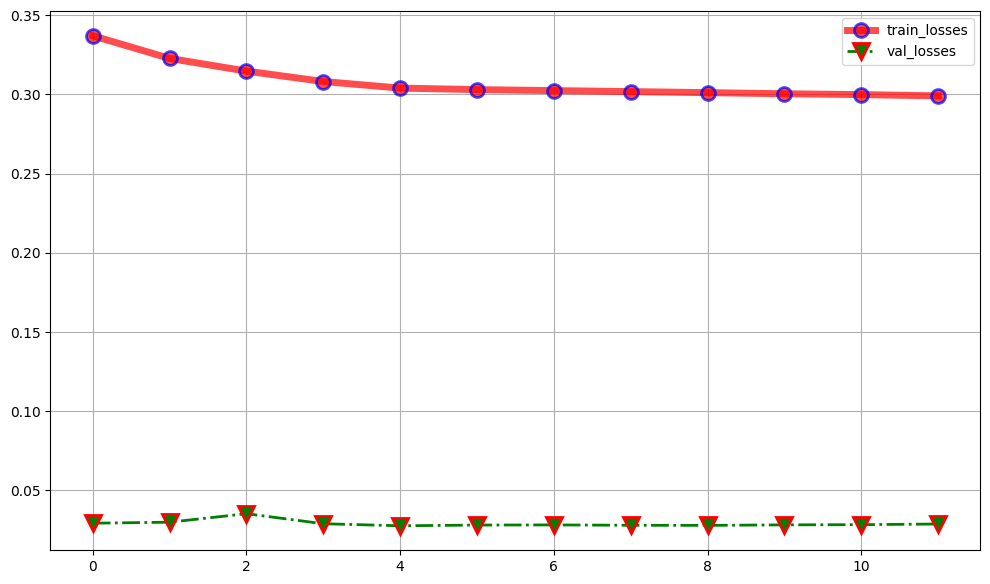

In [194]:
x = np.arange(0,12)
y1 = train_losses
y2 = val_losses
plt.figure(figsize=(12, 7))
plt.plot(x, y1, 'o-r', alpha=0.7, label="train_losses", lw=5, mec='b', mew=2, ms=10)
plt.plot(x, y2, 'v-.g', label="val_losses", mec='r', lw=2, mew=2, ms=12)
plt.legend()
plt.grid(True)

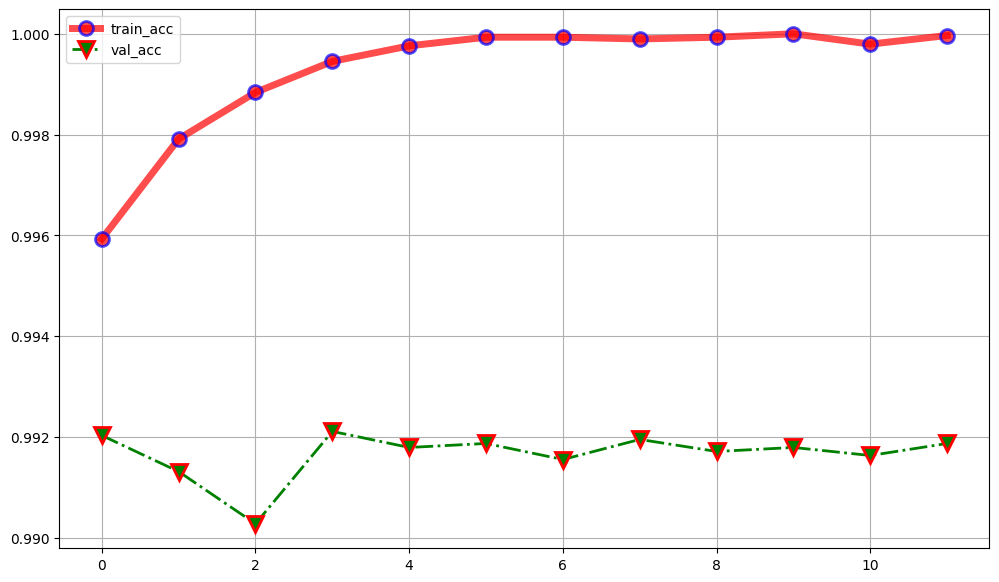

In [195]:
x = np.arange(0,12)
y1 = train_accuracies
y2 = val_accuracies
plt.figure(figsize=(12, 7))
plt.plot(x, y1, 'o-r', alpha=0.7, label="train_acc", lw=5, mec='b', mew=2, ms=10)
plt.plot(x, y2, 'v-.g', label="val_acc", mec='r', lw=2, mew=2, ms=12)
plt.legend()
plt.grid(True)

# **8_Предсказание**

In [198]:
# random выбор картинок
df_test = df.sample(6)
df_test

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
29100,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40788,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23192,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40814,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4809,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25275,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


tensor([8, 6, 5, 4, 7, 1], device='cuda:0')


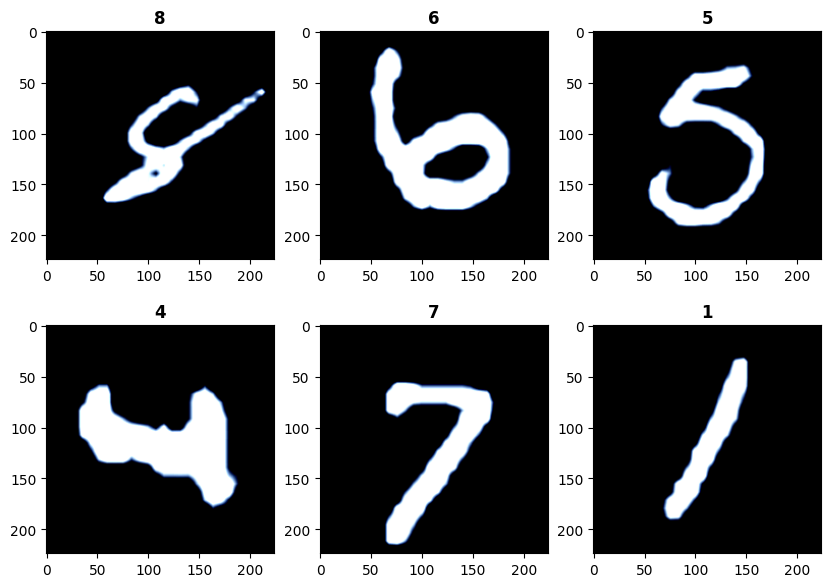

In [199]:
# преобразования для подачи в модель
t = Asbooka(df_test, val_trans)
t_dl = DataLoader(t, batch_size=6, shuffle=True, drop_last = True)

# разделяем картинки и true
for i in t_dl:
    x,y = i
#     print(x)
    print(y)
    
# блок предсказания класса
@torch.no_grad()
def pred(x, model):
    model.eval()
    with torch.no_grad():
        prediction = model(x)
    pred_list = prediction.max(1)[1].detach().cpu().numpy()
    return x.cpu().numpy(), pred_list

# делаем список картинка + предсказание
images, predictions = pred(x, model)
data = list(zip(images, predictions))

fig, ax = plt.subplots(2, 3, figsize=(10, 7))
axs = [ax[i, j] for i in range(2) for j in range(3)]
for _,i in enumerate(data):
    axs[_].set_title(i[1], fontweight ="bold")
    axs[_].imshow(i[0].transpose(1, 2, 0))
#     arrImg = i[0].transpose(1, 2, 0)
#     plt.title(i[1], fontweight ="bold") 
#     plt.imshow(arrImg)

# **Шаг 9: Передаем данные**

In [200]:
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [201]:
test.shape

(28000, 784)

In [202]:
test.head(5)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [207]:
class Asbookatest(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms=transforms
        self.pics = np.array(df)
#         self.targets = np.array(df.iloc[:,0])
#         self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    def __len__(self): return len(self.df)
    def __getitem__(self, ix):
        picture = self.pics[ix]
#         pic=[]
#         for i in np.arange(3):
#           pic.append(picture)
#         print(pic)
        img = np.array(picture).astype(np.uint8)
        img = np.repeat(img.reshape(28,28,1), 3, axis=2) # делаем форму (28,28,3) из (28,28,1)
#         print(img.shape)
#         print(np.repeat(img.reshape(1,28,28), 3, axis=0).shape)
        if self.transforms:
          img=self.transforms(img).to(device)
#         print(img.shape)
#         target = self.targets[ix]
        return img#, torch.tensor(target)
    

In [208]:
test_test = Asbookatest(test, val_trans)
test_loader = DataLoader(test_test, batch_size=1000, shuffle=False)

In [209]:
predictions = []

with torch.no_grad():
    model.eval()  # Set model to evaluation mode
    for data in tqdm(test_loader):
        inputs = data#[0]
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.tolist())

100%|██████████| 28/28 [00:49<00:00,  1.77s/it]


In [210]:
predictions

[2,
 0,
 9,
 0,
 3,
 7,
 0,
 3,
 0,
 3,
 5,
 7,
 4,
 0,
 4,
 3,
 3,
 1,
 9,
 0,
 9,
 1,
 1,
 5,
 7,
 4,
 2,
 7,
 4,
 7,
 7,
 5,
 4,
 2,
 6,
 2,
 5,
 5,
 1,
 6,
 7,
 7,
 4,
 9,
 8,
 7,
 8,
 2,
 6,
 7,
 6,
 8,
 8,
 3,
 8,
 2,
 1,
 2,
 2,
 0,
 4,
 1,
 7,
 0,
 0,
 0,
 1,
 9,
 0,
 1,
 6,
 5,
 8,
 8,
 2,
 8,
 9,
 9,
 2,
 3,
 5,
 4,
 1,
 8,
 9,
 2,
 4,
 3,
 6,
 7,
 2,
 0,
 6,
 6,
 1,
 4,
 3,
 9,
 7,
 4,
 0,
 9,
 2,
 0,
 7,
 3,
 0,
 5,
 0,
 8,
 0,
 0,
 4,
 7,
 1,
 7,
 1,
 1,
 3,
 3,
 3,
 7,
 2,
 8,
 6,
 3,
 8,
 7,
 7,
 4,
 3,
 5,
 6,
 0,
 0,
 0,
 3,
 1,
 3,
 6,
 4,
 3,
 4,
 5,
 5,
 8,
 7,
 7,
 2,
 8,
 4,
 3,
 5,
 6,
 5,
 3,
 7,
 5,
 7,
 8,
 3,
 0,
 4,
 5,
 1,
 2,
 7,
 6,
 3,
 0,
 2,
 7,
 8,
 6,
 1,
 3,
 7,
 4,
 1,
 2,
 4,
 8,
 5,
 2,
 4,
 9,
 2,
 1,
 6,
 0,
 6,
 1,
 4,
 9,
 6,
 0,
 9,
 7,
 6,
 9,
 1,
 9,
 0,
 9,
 9,
 0,
 8,
 4,
 6,
 2,
 0,
 9,
 3,
 6,
 3,
 2,
 1,
 6,
 3,
 4,
 2,
 3,
 1,
 2,
 2,
 0,
 4,
 6,
 1,
 0,
 0,
 4,
 9,
 1,
 7,
 3,
 2,
 3,
 8,
 6,
 8,
 6,
 2,
 8,
 5,
 5,
 4,
 8,
 3,
 5,


In [211]:
submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
print(submission)

       ImageId  Label
0            1      0
1            2      0
2            3      0
3            4      0
4            5      0
...        ...    ...
27995    27996      0
27996    27997      0
27997    27998      0
27998    27999      0
27999    28000      0

[28000 rows x 2 columns]


In [212]:
pred = pd.DataFrame({'ImageId': range(1, len(predictions) + 1), 'Label': predictions})
submission = pd.merge(submission['ImageId'], pred, on='ImageId')
submission.to_csv('submission.csv', index=False)

In [213]:
pred

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
